Candidate Number: 284039

# Stock Price Forecasting using ARIMA

+ The models were tested on 6 financial markets: Amazon, CAC, IBM, Microsoft, Nasdaq, and S&P 500.

# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import scipy.stats as scs
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from scipy.stats import normaltest
from statsmodels.tsa.stattools import acf,pacf
import scipy.interpolate as sci
import scipy.optimize as sco
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from math import ceil

# Loading data

In [2]:
import yfinance as yf
import pandas as pd
from datetime import datetime

# Define the start and end dates for fetching historical data
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

# Define the tickers for the companies and indices
tickers = {
    'Amazon': 'AMZN',
    'CAC': '^FCHI',
    'IBM': 'IBM',
    'Microsoft': 'MSFT',
    'Nasdaq': '^IXIC',
    'S&P 500': '^GSPC'
}

# Create an empty dictionary to store the dataframes
stock_data = {}

# Fetch the data for each ticker
for name, ticker in tickers.items():
    print(f'Fetching data for {name} ({ticker})...')
    stock_data[name] = yf.download(ticker, start=start_date, end=end_date)
    print(f'Data for {name} ({ticker}) fetched successfully.')

# Optionally, save the data to CSV files
for name, df in stock_data.items():
    df.to_csv(f'{name}_data.csv')
    print(f'Data for {name} saved to {name}_data.csv')


Fetching data for Amazon (AMZN)...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for Amazon (AMZN) fetched successfully.
Fetching data for CAC (^FCHI)...
Data for CAC (^FCHI) fetched successfully.
Fetching data for IBM (IBM)...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for IBM (IBM) fetched successfully.
Fetching data for Microsoft (MSFT)...
Data for Microsoft (MSFT) fetched successfully.
Fetching data for Nasdaq (^IXIC)...


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Data for Nasdaq (^IXIC) fetched successfully.
Fetching data for S&P 500 (^GSPC)...
Data for S&P 500 (^GSPC) fetched successfully.
Data for Amazon saved to Amazon_data.csv
Data for CAC saved to CAC_data.csv
Data for IBM saved to IBM_data.csv
Data for Microsoft saved to Microsoft_data.csv
Data for Nasdaq saved to Nasdaq_data.csv
Data for S&P 500 saved to S&P 500_data.csv


In [3]:
stock_data.keys()

dict_keys(['Amazon', 'CAC', 'IBM', 'Microsoft', 'Nasdaq', 'S&P 500'])

In [4]:
amazon = stock_data['Amazon']
cac = stock_data['CAC']
ibm = stock_data['IBM']
microsoft = stock_data['Microsoft']
nasdaq = stock_data['Nasdaq']
sp500 = stock_data['S&P 500']

In [5]:
amazon.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,6.8125,6.8305,6.6570,6.6950,6.6950,151998000
2010-01-05,6.6715,6.7740,6.5905,6.7345,6.7345,177038000
2010-01-06,6.7300,6.7365,6.5825,6.6125,6.6125,143576000
2010-01-07,6.6005,6.6160,6.4400,6.5000,6.5000,220604000
2010-01-08,6.5280,6.6840,6.4515,6.6760,6.6760,196610000


In [6]:
# Assume dfs is a list of your DataFrames
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

for i, df in enumerate(dfs):
    df.reset_index(inplace=True)
    print(f"DataFrame {i} columns: {df.columns}")
    

# Function to check and rename the 'Date' column if necessary
def ensure_date_column(df):
    # Strip any leading/trailing whitespace from column names
    df.columns = df.columns.str.strip()
    # Check if 'Date' column exists
    if 'Date' not in df.columns:
        raise KeyError(f"'Date' column not found in DataFrame with columns: {df.columns}")
    return df

# Apply the function to each DataFrame
dfs = [ensure_date_column(df) for df in dfs]


DataFrame 0 columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DataFrame 1 columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DataFrame 2 columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DataFrame 3 columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DataFrame 4 columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
DataFrame 5 columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [7]:
# list of DataFrames (dfs)
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

for df in dfs:
  df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Preprocessing data

In [8]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

# list of names
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  print(f"{name}: {df.shape}")

amazon: (3678, 7)
cac: (3739, 7)
ibm: (3678, 7)
microsoft: (3678, 7)
nasdaq: (3678, 7)
sp500: (3678, 7)


In [9]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

null_dfs = []

for df, name in zip(dfs, names):
  null_count_df = pd.DataFrame(df.isnull().sum(), columns=[name])
  null_dfs.append(null_count_df)

# concatenate dfs horizontally
result_df = pd.concat(null_dfs, axis=1)

print(result_df)

           amazon  cac  ibm  microsoft  nasdaq  sp500
Date            0    0    0          0       0      0
Open            0    0    0          0       0      0
High            0    0    0          0       0      0
Low             0    0    0          0       0      0
Close           0    0    0          0       0      0
Adj Close       0    0    0          0       0      0
Volume          0    0    0          0       0      0


In [10]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
    df.dropna(inplace=True)

In [11]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

null_dfs = []

for df, name in zip(dfs, names):
  null_count_df = pd.DataFrame(df.isnull().sum(), columns=[name])
  null_dfs.append(null_count_df)

# concatenate dfs horizontally
result_df = pd.concat(null_dfs, axis=1)

print(result_df)

           amazon  cac  ibm  microsoft  nasdaq  sp500
Date            0    0    0          0       0      0
Open            0    0    0          0       0      0
High            0    0    0          0       0      0
Low             0    0    0          0       0      0
Close           0    0    0          0       0      0
Adj Close       0    0    0          0       0      0
Volume          0    0    0          0       0      0


In [12]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  duplicates = df.duplicated()
  num_duplicates = duplicates.sum()
  print(f"Duplicated rows in {name}: {num_duplicates}")

Duplicated rows in amazon: 0
Duplicated rows in cac: 0
Duplicated rows in ibm: 0
Duplicated rows in microsoft: 0
Duplicated rows in nasdaq: 0
Duplicated rows in sp500: 0


In [13]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  print(f"Data types of columns in {name} dataset:")
  print(df.dtypes)

Data types of columns in amazon dataset:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object
Data types of columns in cac dataset:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object
Data types of columns in ibm dataset:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object
Data types of columns in microsoft dataset:
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

In [14]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

# list of names
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

for df, name in zip(dfs, names):
  print(f"{name}: {df.shape}")

amazon: (3678, 7)
cac: (3739, 7)
ibm: (3678, 7)
microsoft: (3678, 7)
nasdaq: (3678, 7)
sp500: (3678, 7)


# EDA

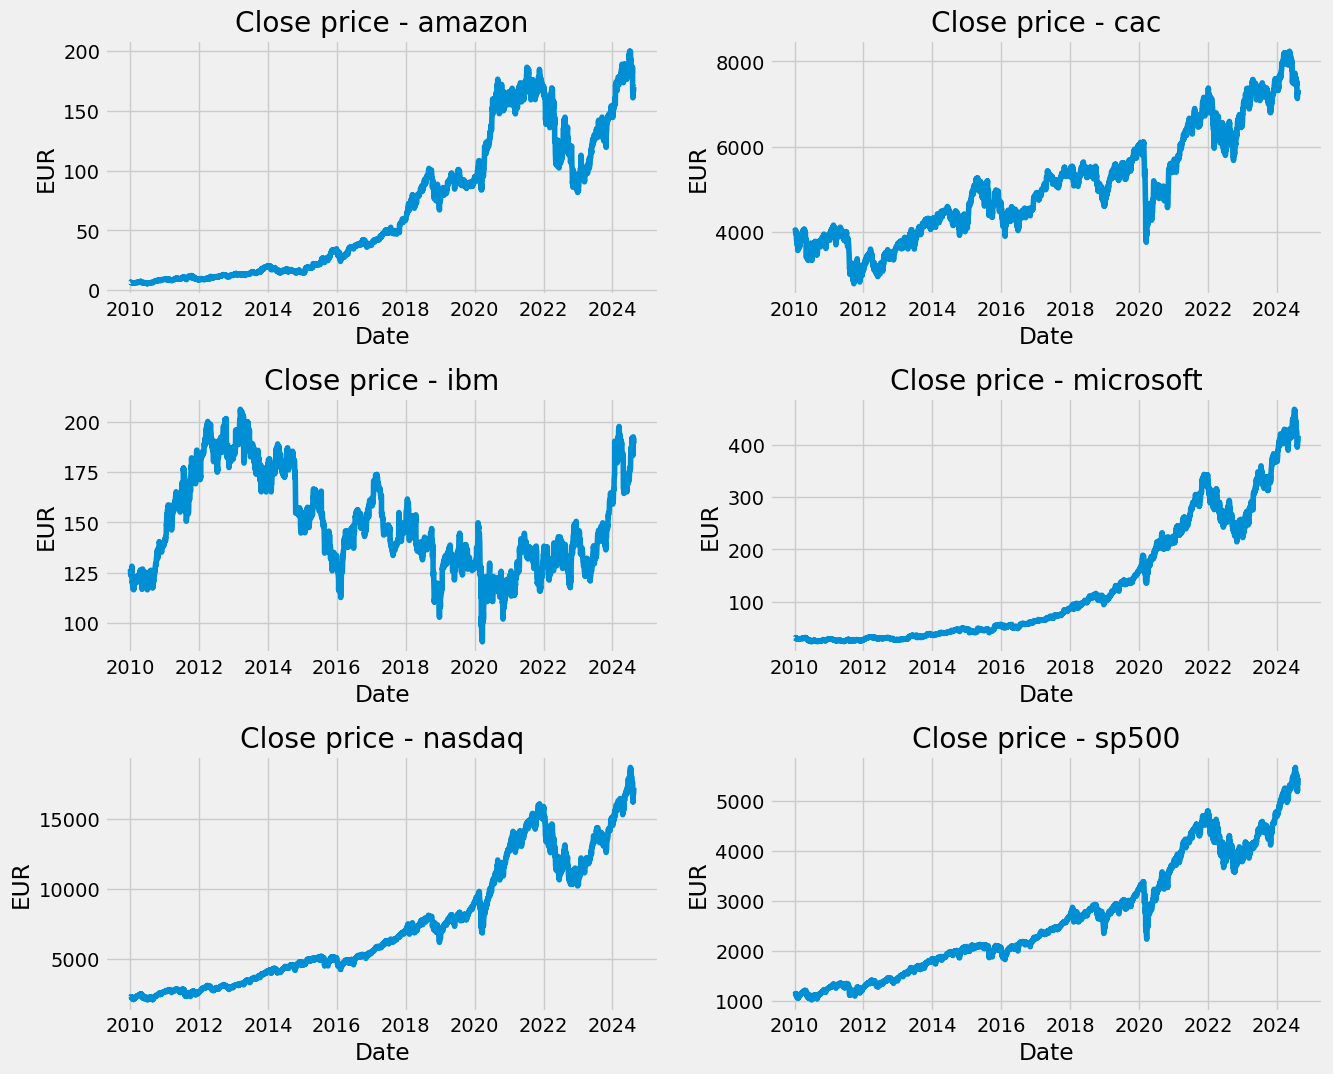

In [15]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['amazon', 'cac', 'ibm', 'microsoft', 'nasdaq', 'sp500']

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

for df, name, ax in zip(dfs, names, axes.flatten()):
  df['Date'] = pd.to_datetime(df['Date'])
  sns.lineplot(data=df, x='Date', y='Close', ax=ax)
  ax.set_title(f'Close price - {name}')
  ax.set_xlabel('Date')
  ax.set_ylabel('EUR')
  ax.grid(True)
  # setting x-axis date format to display years
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()

# Stationary data check

For ARIMA, we need to check for the Stationarity of data.

In [16]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

results_list = []

for df, name in zip(dfs, names):
  result = adfuller(df['Close'])
  results_list.append({'Name': name, 'ADF Statistic': result[0], 'p-value': result[1]})

# converting list of dictionaries to df
adf_results_df = pd.DataFrame(results_list)

print(adf_results_df.to_string(index=False))

     Name  ADF Statistic  p-value
   Amazon      -0.143629 0.944916
      CAC      -0.990026 0.756885
      IBM      -2.276410 0.179689
Microsoft       2.101916 0.998792
   NASDAQ       0.744774 0.990690
    SP500       0.866489 0.992637


First,
+ about ADF, all the values should be negative and further than 0, if they are positive and close 0, it means data is not stationary.
+ looking at p-value, is bigger than the critical point >0.05 in all the dfs, which means the data in dfs is not stationary.

So, we need to make it stationary before applying ARIMA.


### Seasonal decomposition

Seasonal decomposition is an important step in time series analysis. It decomposes time series to the components like: trend, seasonality, and noise (or residual).

In [17]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]

df = pd.concat([df.set_index('Date')['Close'] for df in dfs], axis=1, join='outer', keys=['AMAZON', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500'])
df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
df.index.name = 'Date'

df.head()

,AMAZON,CAC,IBM,Microsoft,NASDAQ,SP500
Date,,,,,,
2010-01-04,6.6950,4013.969971,126.625237,30.950001,2308.419922,1132.989990
2010-01-05,6.7345,4012.909912,125.095604,30.959999,2308.709961,1136.520020
2010-01-06,6.6125,4017.669922,124.282982,30.770000,2301.090088,1137.140015
2010-01-07,6.5000,4024.800049,123.852776,30.450001,2300.050049,1141.689941
2010-01-08,6.6760,4045.139893,125.095604,30.660000,2317.169922,1144.979980


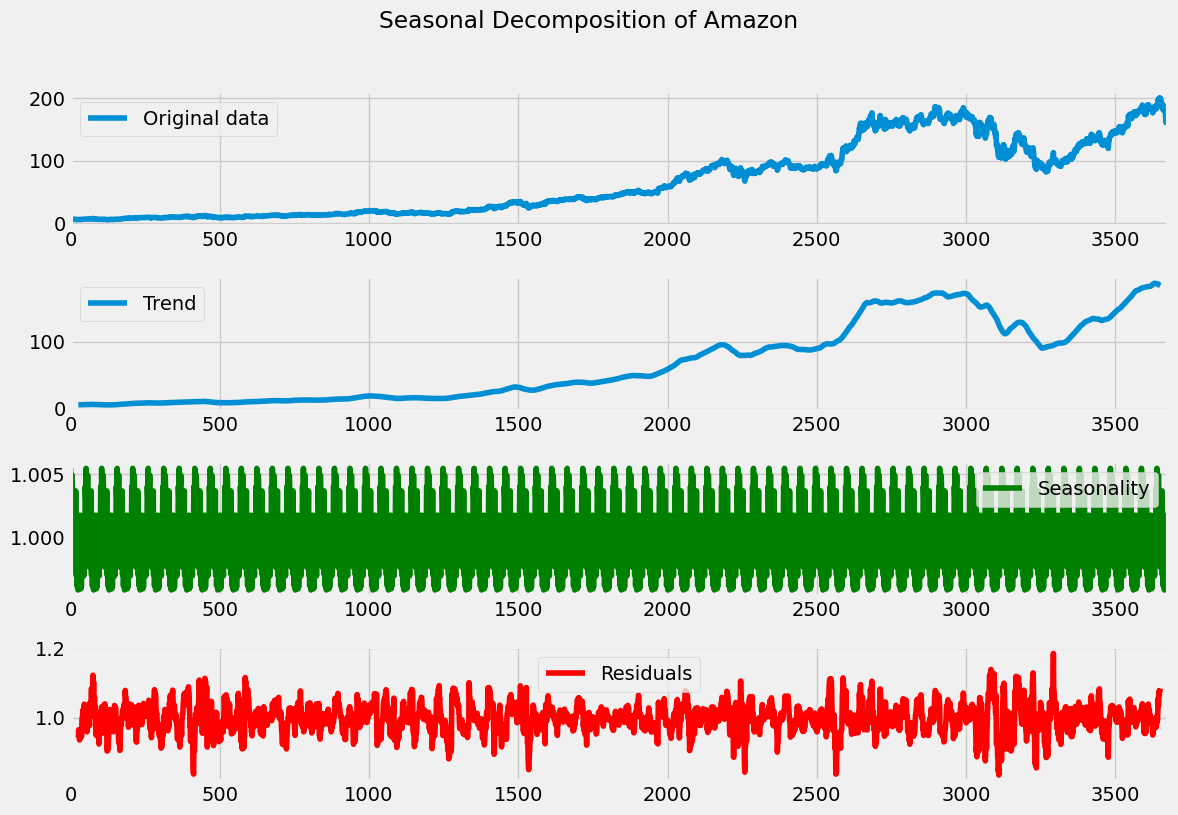

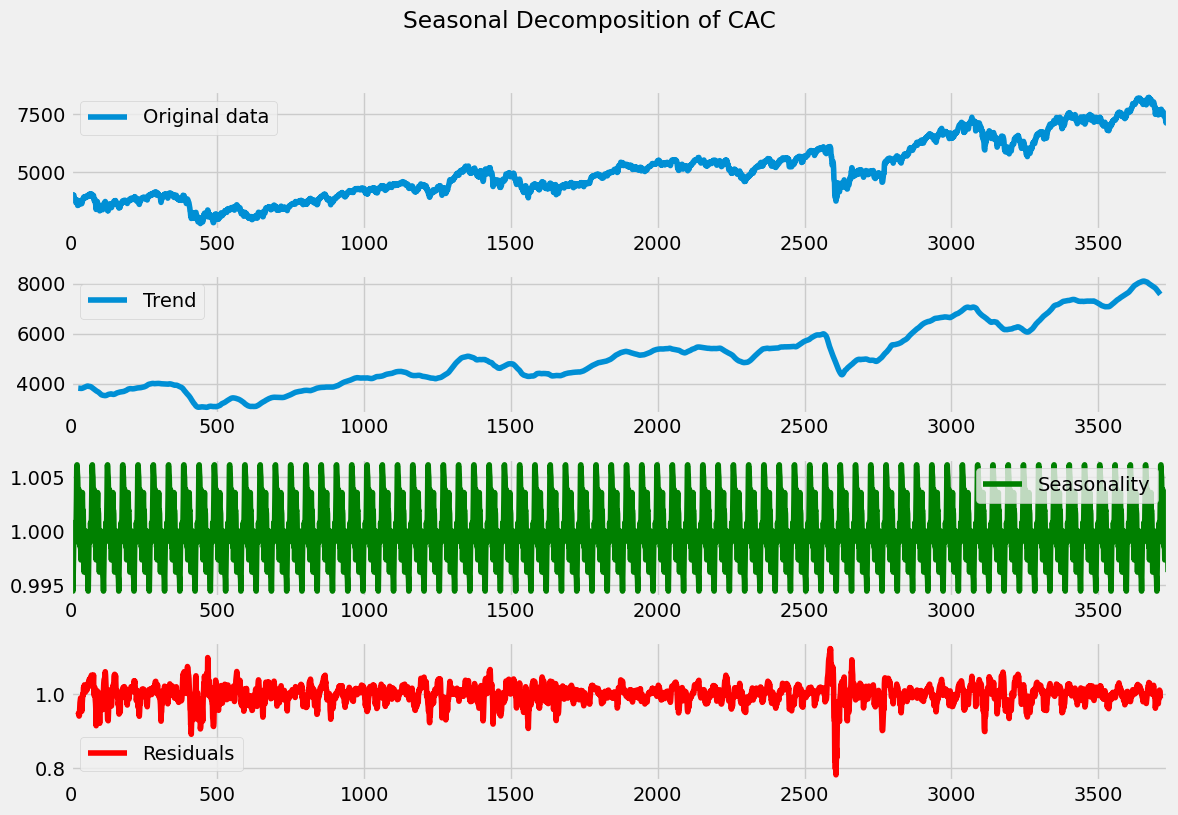

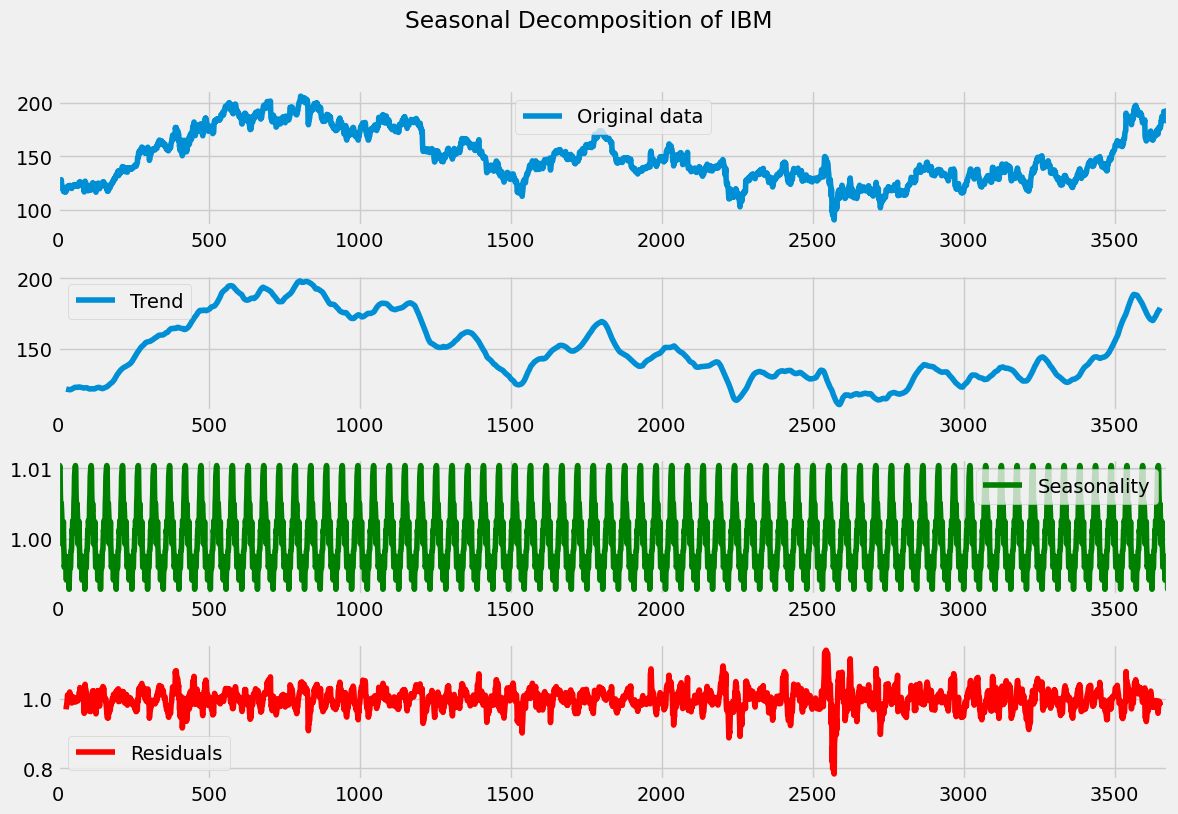

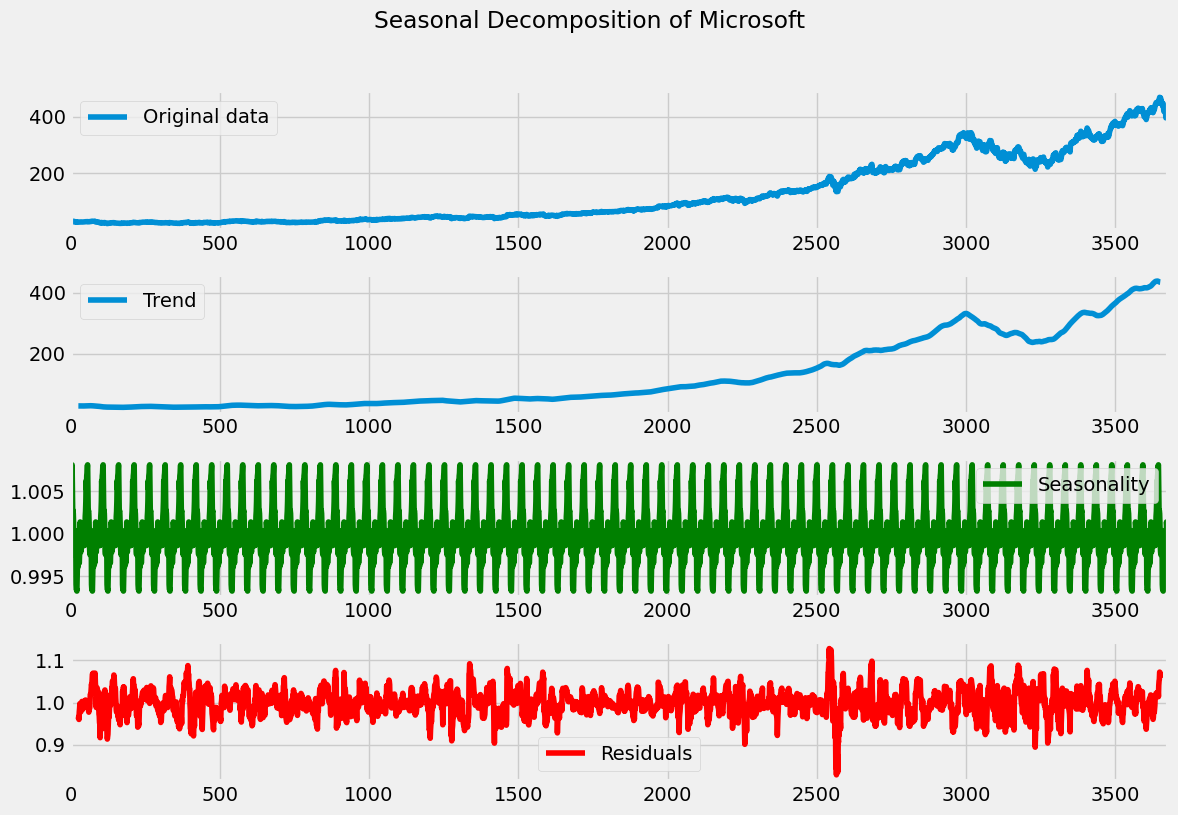

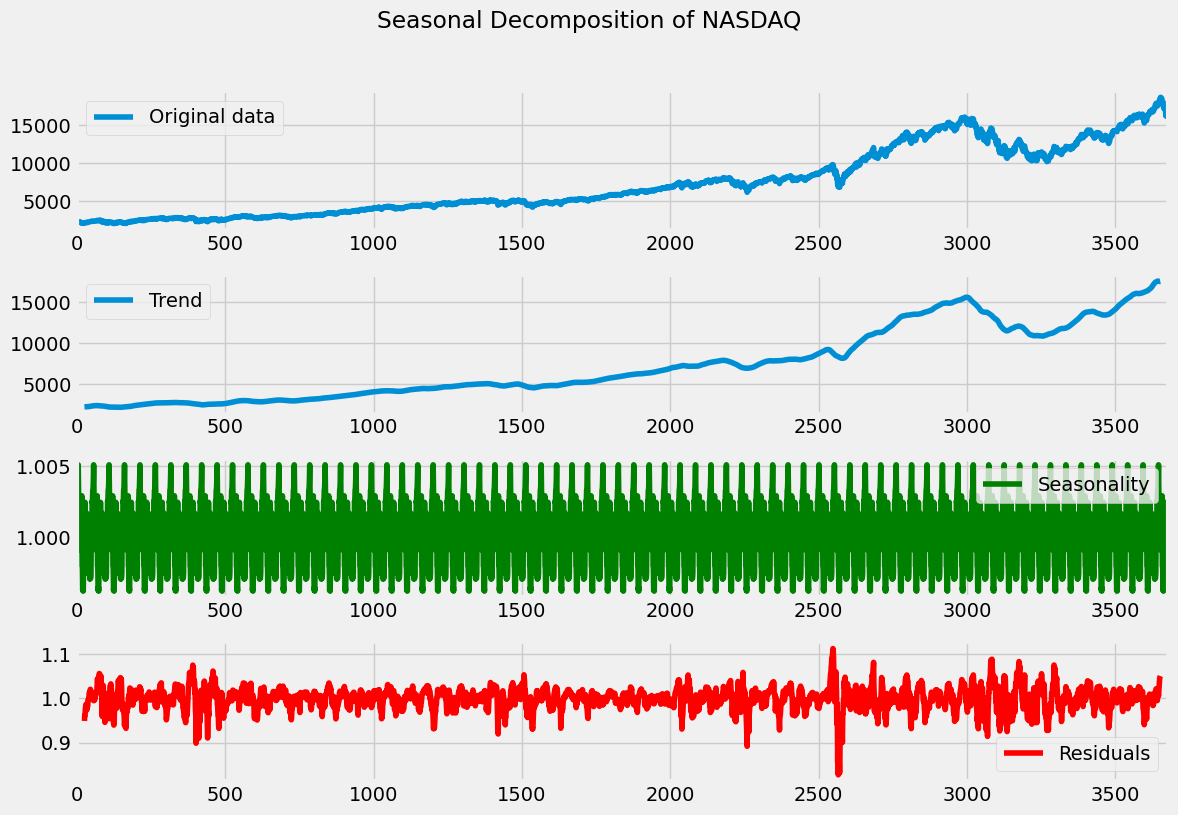

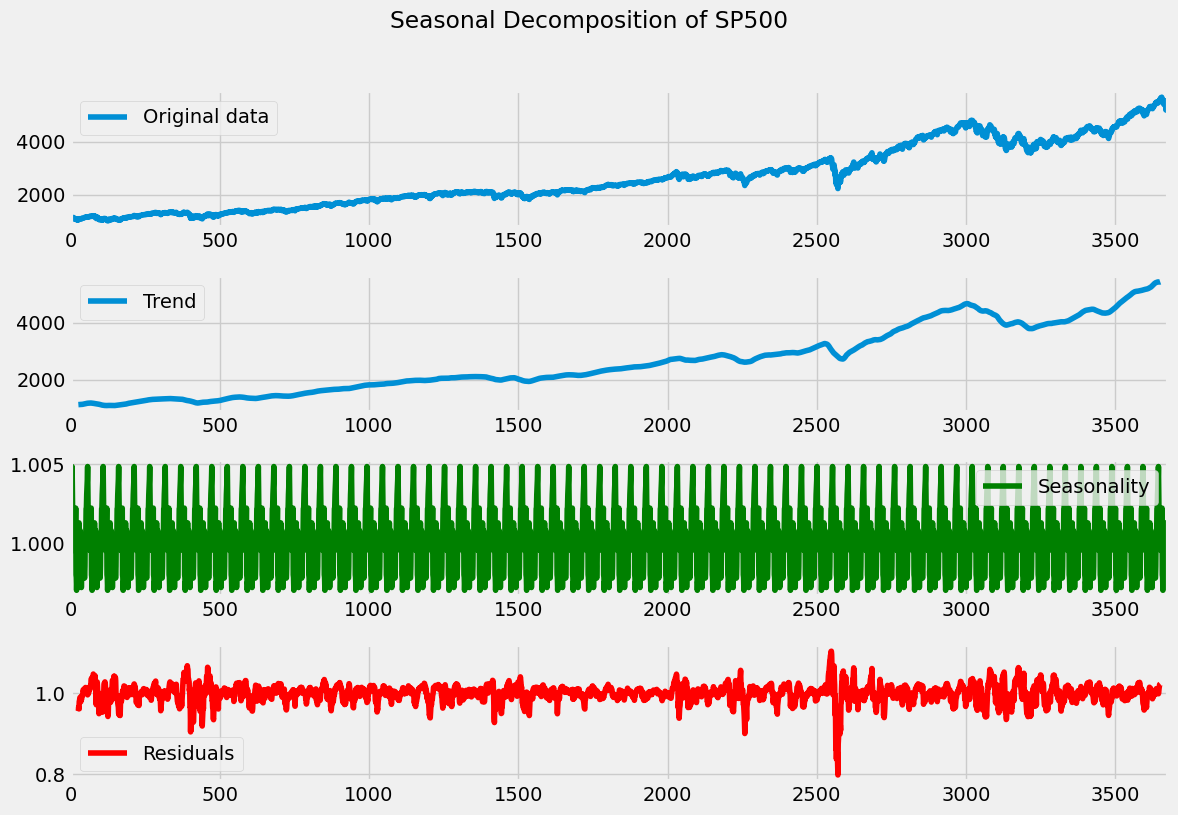

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

for df, name in zip(dfs, names):
    # period = 52 means we believe there is annual seasonal pattern
    result = seasonal_decompose(df['Close'], model='multiplicative', period=52)

    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    axes[0].plot(df.index, df['Close'], label='Original data')
    axes[0].legend()
    axes[1].plot(df.index, result.trend, label='Trend')
    axes[1].legend()
    axes[2].plot(df.index, result.seasonal, label='Seasonality', color='green')
    axes[2].legend()
    axes[3].plot(df.index, result.resid, label='Residuals', color='red')
    axes[3].legend()

    # Set the x-axis limits to match the date range of the data
    axes[0].set_xlim(df.index.min(), df.index.max())
    axes[1].set_xlim(df.index.min(), df.index.max())
    axes[2].set_xlim(df.index.min(), df.index.max())
    axes[3].set_xlim(df.index.min(), df.index.max())

    # Format x-axis to display years
    #for ax in axes:
       # ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    plt.suptitle(f'Seasonal Decomposition of {name}', y=1.02)
    plt.tight_layout()
    plt.show()


Augmented Dickey-Fuller (ADF) test

In [19]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

results_list = []

for df, name in zip(dfs, names):
  result = adfuller(df['Close'])
  results_list.append({'Name': name, 'ADF Statistic': result[0], 'p-value': result[1]})

# converting list of dictionaries to df
adf_results_df = pd.DataFrame(results_list)

print(adf_results_df.to_string(index=False))

     Name  ADF Statistic  p-value
   Amazon      -0.143629 0.944916
      CAC      -0.990026 0.756885
      IBM      -2.276410 0.179689
Microsoft       2.101916 0.998792
   NASDAQ       0.744774 0.990690
    SP500       0.866489 0.992637


### Log Transformation

Log transformation is a technique used to stabilize variance, reduce skewness, and make the data conform more closely to the assumptions of statistical tests and models. It involves taking the logarithm of the values in a dataset, typically using the natural logarithm (base e) or the base 10 logarithm.

In [20]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

results_list = []

for df, name in zip(dfs, names):
  timeseries_log = np.log(df['Close'])
  timeseries_log_diff = timeseries_log.diff().dropna()

  result = adfuller(timeseries_log_diff)

  adf_statistic = result[0]
  p_value = result[1]

  critical_values = result[4]

  critical_value_1pct = critical_values['1%']
  critical_value_5pct = critical_values['5%']
  critical_value_10pct = critical_values['10%']

  if p_value < 0.05:
    stationarity = 'Stationary'
  else:
    stationarity = 'Not stationary'

  results_list.append({'Name': name, 'ADF Statistic': adf_statistic,
                      'p-value': p_value, 'Critical Value (1%)': critical_value_1pct,
                      'Critical Value (5%)': critical_value_5pct,
                      'Critical Value (10%)': critical_value_10pct, 'Stationarity': stationarity})

adf_results_df = pd.DataFrame(results_list)

print(adf_results_df.to_string(index=False))

     Name  ADF Statistic      p-value  Critical Value (1%)  Critical Value (5%)  Critical Value (10%) Stationarity
   Amazon     -61.647371 0.000000e+00            -3.432130            -2.862327             -2.567189   Stationary
      CAC     -22.378636 0.000000e+00            -3.432104            -2.862315             -2.567183   Stationary
      IBM     -12.598006 1.761347e-23            -3.432145            -2.862333             -2.567192   Stationary
Microsoft     -21.385912 0.000000e+00            -3.432134            -2.862328             -2.567190   Stationary
   NASDAQ     -13.556363 2.355740e-25            -3.432142            -2.862332             -2.567192   Stationary
    SP500     -13.177963 1.212373e-24            -3.432143            -2.862332             -2.567192   Stationary


Now, everything is ok, the data is stationary.

In [21]:
normality_results = []

for df, name in zip(dfs, names):
  timeseries_log = np.log(df['Close'])
  timeseries_log_diff = timeseries_log.diff().dropna()
  stat, p = normaltest(timeseries_log_diff)

  alpha = 0.05
  if p > alpha:
    normality = 'Normally distributed (fail to reject H0)'
  else:
    normality = 'Is not normally distributed (reject H0)'

  normality_results.append({'Name': name, 'Test Statistic': stat, 'p-value': p, 'Normality': normality})

normality_df = pd.DataFrame(normality_results)

print(normality_df.to_string(index=False))

     Name  Test Statistic       p-value                               Normality
   Amazon      472.403669 2.623292e-103 Is not normally distributed (reject H0)
      CAC      712.505325 1.911765e-155 Is not normally distributed (reject H0)
      IBM      892.257553 1.773104e-194 Is not normally distributed (reject H0)
Microsoft      589.423810 1.019168e-128 Is not normally distributed (reject H0)
   NASDAQ      732.427582 9.023426e-160 Is not normally distributed (reject H0)
    SP500     1015.387636 3.246208e-221 Is not normally distributed (reject H0)


There is a need to see why data is not normally distributed, so we can check with the help of skewness.

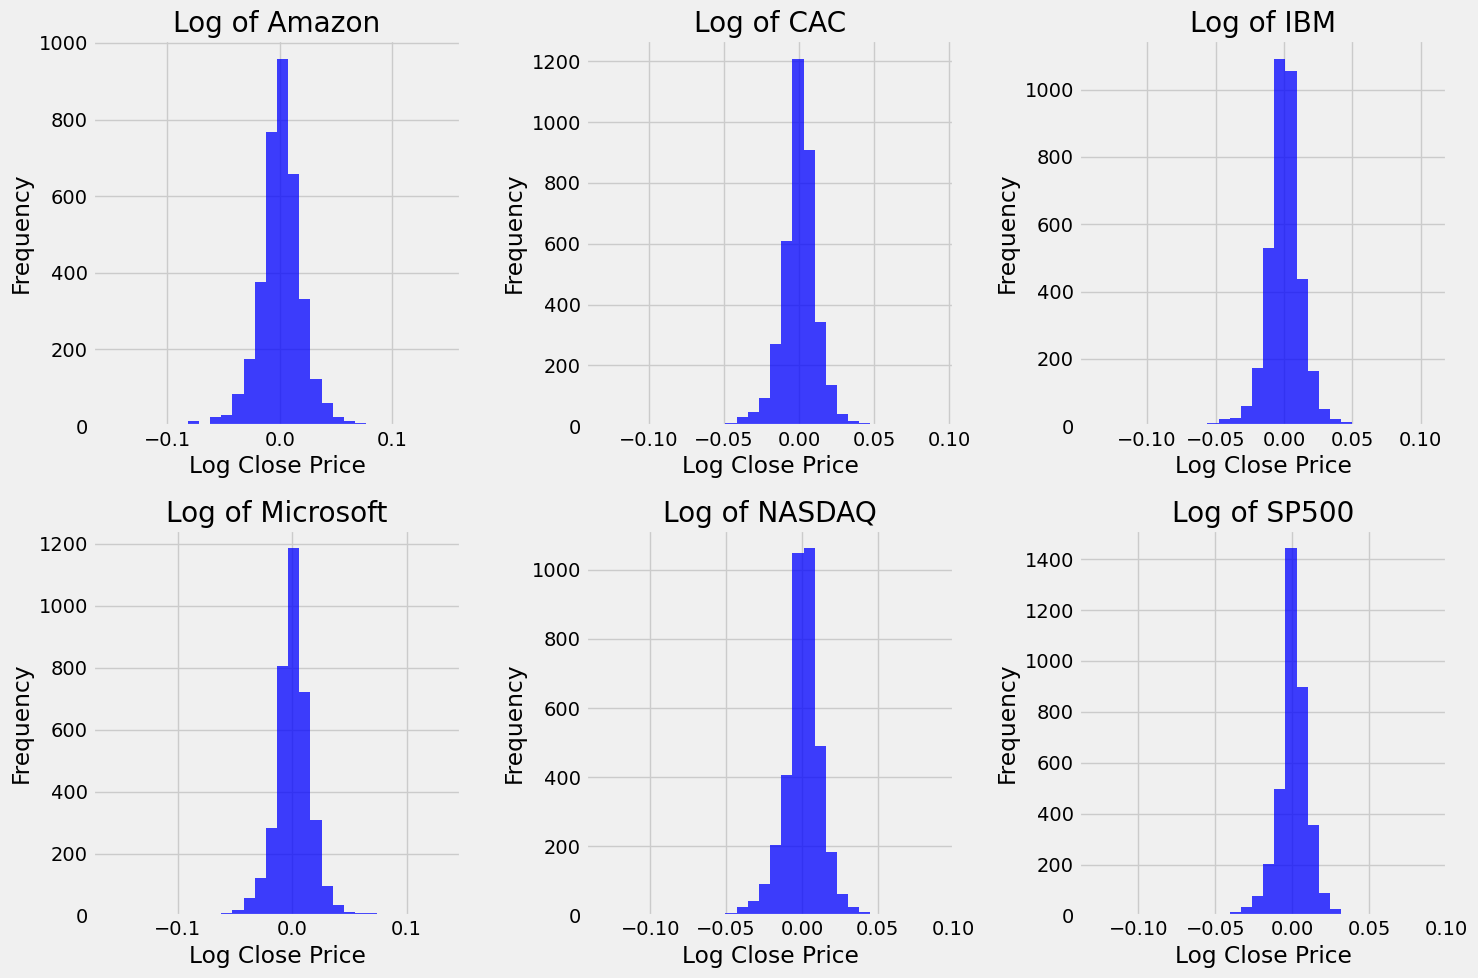

In [22]:
dfs = [amazon, cac, ibm, microsoft, nasdaq, sp500]
names = ['Amazon', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for ax, df, name in zip(axes, dfs, names):
  timeseries_log = np.log(df['Close'])
  timeseries_log_diff = timeseries_log.diff().dropna()
  ax.hist(timeseries_log_diff, bins=30, alpha=0.75, color='blue')
  ax.set_title(f'Log of {name}')
  ax.set_xlabel('Log Close Price')
  ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

Looking at the skewness of all the graphs, they are all likely to be distributed normally, so we can fit the model now!

# Fit the model

## ARIMA (AutoRegressive Integrated Moving Average)

In [23]:
  shape = amazon.shape[0]
  df_new1 = amazon[['Close']]
  df_new1['Close'] = np.log(df_new1['Close'])

  train_set1 = df_new1.iloc[:ceil(shape * 0.8)]

In [24]:
train_set1

,Close
0,1.901361
1,1.907244
2,1.888962
3,1.871802
4,1.898519
...,...
2938,5.158495
2939,5.167437
2940,5.172045
2941,5.160250


In [25]:
def arima_model(df):
  shape = df.shape[0]
  df_new = df[['Close']]
  df_new['Close'] = np.log(df_new['Close'])

  train_set = df_new.iloc[:ceil(shape * 0.8)]
  valid_set = df_new.iloc[ceil(shape * 0.8):]

  print('Training Set:', train_set.shape)
  print('Validation Set:', valid_set.shape)

  training = train_set['Close']
  validation = valid_set['Close']

  model = auto_arima(training, start_p=0, start_q=0, max_p=3, max_q=3, start_P=0, seasonal=True, d=1, D=1, trace=True, error_action='ignore', suppress_warnings=True)
  model.fit(training)

  forecast = model.predict(n_periods=len(validation))
  forecast.index = validation.index
  forecast = pd.DataFrame(forecast,columns =['Prediction'])
  rmse = np.sqrt(np.mean(np.power((np.array(validation) - np.array(forecast['Prediction'])), 2)))
  print('RMSE value on validation set:', rmse)
  plt.plot(train_set['Close'])
  plt.plot(valid_set['Close'])
  plt.plot(forecast['Prediction'])
  plt.title('Stocks Price Prediction \n')
  plt.xlabel('Date')
  plt.ylabel('Actual Stock Price')
  plt.legend(['Model Training Data', 'Actual Data', 'Predicted Data'])
  plt.show()

In [26]:
amazon.set_index('Date',inplace=True)
cac.set_index('Date',inplace=True)
ibm.set_index('Date',inplace=True)
microsoft.set_index('Date',inplace=True)
nasdaq.set_index('Date',inplace=True)
sp500.set_index('Date',inplace=True)

Training Set: (2943, 1)
Validation Set: (735, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-14761.514, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-14761.298, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-14761.344, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-14754.229, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-14763.457, Time=0.23 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-14757.784, Time=0.70 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-14759.494, Time=0.72 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-14759.869, Time=0.37 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-14759.762, Time=0.15 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-14759.175, Time=0.63 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-14753.050, Time=0.12 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 3.488 seconds
RMSE value on validation set: 0.7065050063256624


/Users/diviteja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


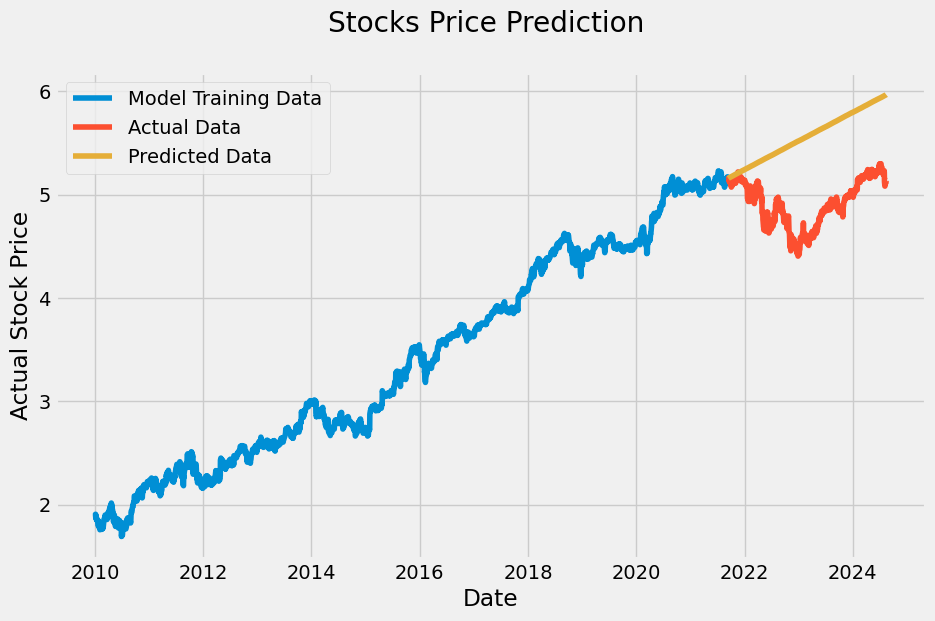

In [27]:
arima_model(amazon)

Training Set: (2992, 1)
Validation Set: (747, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17529.131, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17527.183, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17527.182, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17530.628, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17525.187, Time=0.21 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.644 seconds
RMSE value on validation set: 0.10186996698006215


/Users/diviteja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


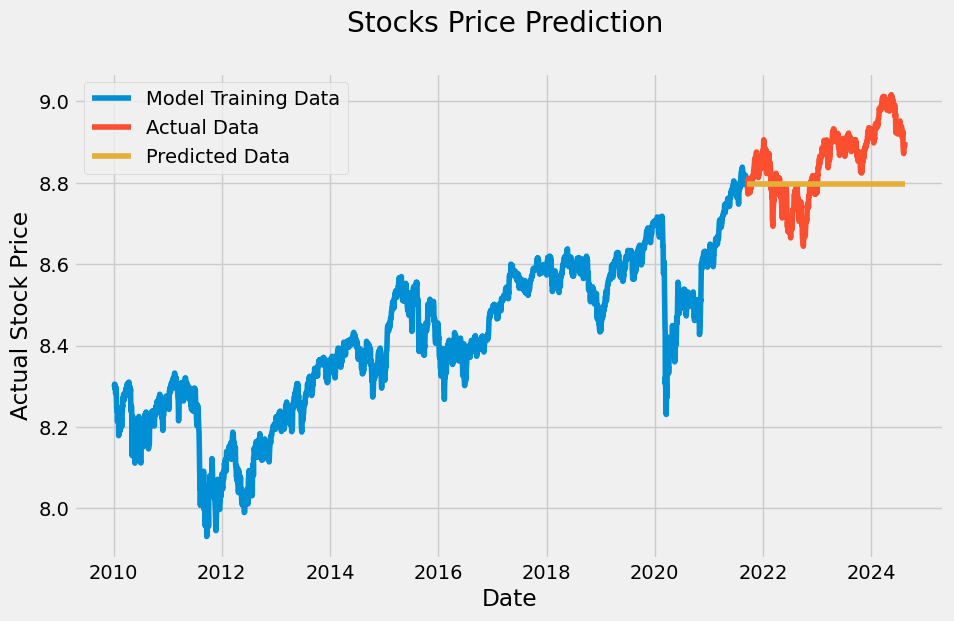

In [28]:
arima_model(cac)

Training Set: (2943, 1)
Validation Set: (735, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16677.802, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16684.494, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16684.018, Time=0.19 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16679.800, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16684.902, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-16684.282, Time=0.32 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16682.883, Time=0.61 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16680.876, Time=0.25 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-16682.391, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-16686.900, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16686.492, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=-16686.280, Time=0.05 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-16689.740, Time=0.29 sec
 ARIMA(1,1,1)(0,0,0)[0] 

/Users/diviteja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


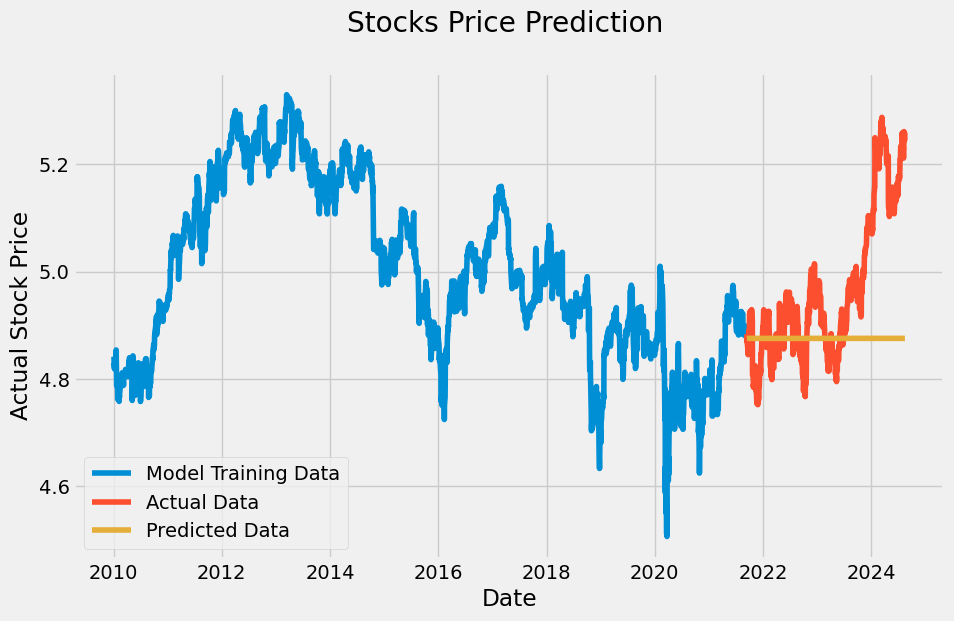

In [29]:
arima_model(ibm)

Training Set: (2943, 1)
Validation Set: (735, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-16038.516, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-16089.745, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-16087.379, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-16033.620, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-16088.262, Time=0.38 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-16088.161, Time=0.46 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-16086.235, Time=0.59 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-16082.737, Time=0.03 sec

Best model:  ARIMA(1,1,0)(0,0,0)[0] intercept
Total fit time: 1.919 seconds
RMSE value on validation set: 0.26237746838897724


/Users/diviteja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


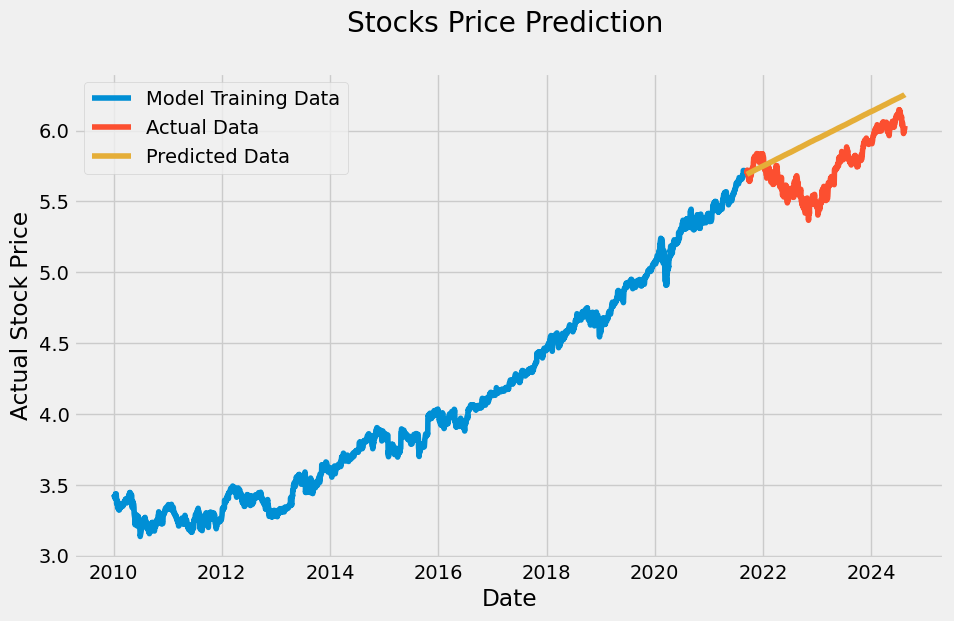

In [30]:
arima_model(microsoft)

Training Set: (2943, 1)
Validation Set: (735, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-17550.903, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-17595.669, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17590.005, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-17544.912, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-17605.438, Time=0.19 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-17604.347, Time=0.49 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-17603.322, Time=0.52 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-17601.359, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-17602.529, Time=0.83 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-17598.432, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.907 seconds
RMSE value on validation set: 0.3772121540214436


/Users/diviteja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


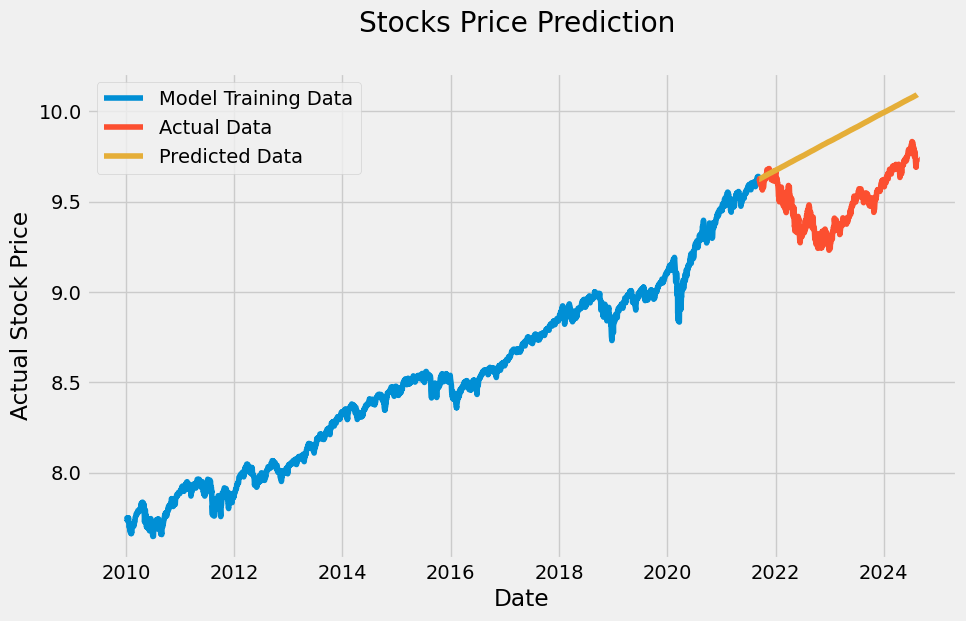

In [31]:
arima_model(nasdaq)

Training Set: (2943, 1)
Validation Set: (735, 1)
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-18237.007, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-18302.804, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-18292.438, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-18233.642, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-18319.858, Time=0.28 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-18318.091, Time=0.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-18317.761, Time=0.75 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-18311.284, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-18316.287, Time=0.80 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-18315.695, Time=0.08 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 2.898 seconds
RMSE value on validation set: 0.20436066854438473


/Users/diviteja/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


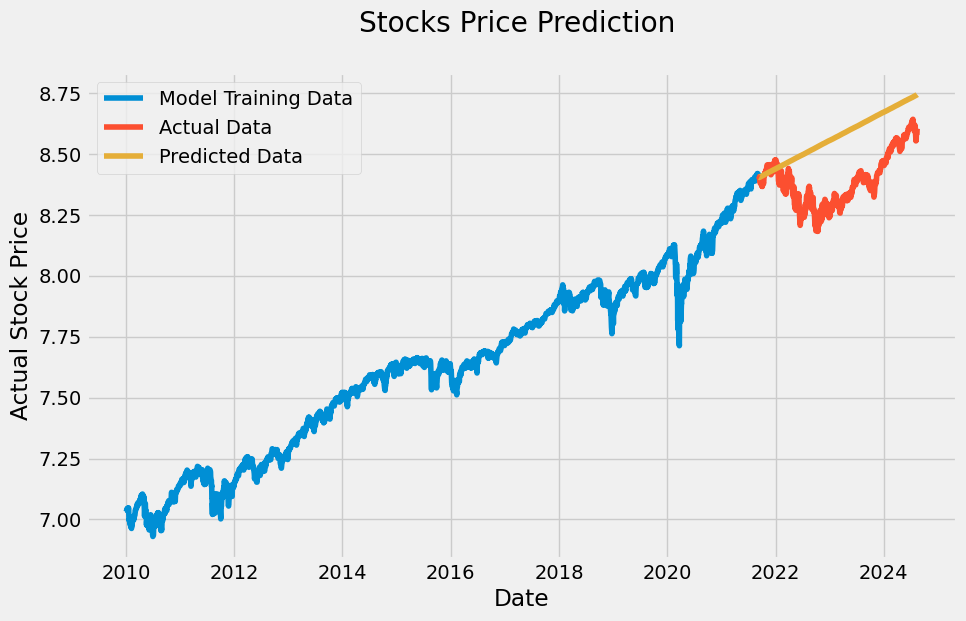

In [32]:
arima_model(sp500)

In [33]:
rmse_values = [2.3199, 0.1894, 0.4494, 0.3788, 0.1858, 0.1102]
names = ['AMAZON', 'CAC', 'IBM', 'Microsoft', 'NASDAQ', 'SP500']
rmse_df = pd.DataFrame({'Name': names, 'RMSE': rmse_values})

print(rmse_df.to_string(index=False))

     Name   RMSE
   AMAZON 2.3199
      CAC 0.1894
      IBM 0.4494
Microsoft 0.3788
   NASDAQ 0.1858
    SP500 0.1102


## Conclusion on ARIMA
+ The best RMSE on 6 datasets with ARIMA is 0.1102 on SP500.
+ The worst RMSE is 2.3199 on AMAZON.

## LSTM

importing libraries for lstm

In [34]:
!pip install pandas-ta
import pandas_ta as ta
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate

### SP500

In [35]:
sp500.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [36]:
sp500.dropna(inplace=True)
sp500.shape

(3678, 6)

In [37]:
sp500.drop(["Volume"], axis = 1, inplace =True)

In [38]:
#adding technical indicators
sp500['RSI'] = ta.rsi(sp500.Close, length = 14)
sp500['EMAF'] = ta.ema(sp500.Close, length = 20)
sp500['EMAM'] = ta.ema(sp500.Close, length = 50)
sp500['EMAS'] = ta.ema(sp500.Close, length = 100)

sp500['Target'] = sp500['Close']-sp500.Open
sp500['Target'] = sp500['Target'].shift(-1)

sp500['TargetClass'] = [1 if sp500.Target[i]>0 else 0 for i in range(len(sp500))]

sp500['TargetNextClose'] = sp500['Close'].shift(-1)

sp500.dropna(inplace =True)

In [39]:
sp500

,Open,High,Low,Close,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,
2010-05-26,1075.510010,1090.750000,1065.589966,1067.949951,1067.949951,31.770290,1124.408430,1145.002973,1139.916196,28.790039,1,1103.060059
2010-05-27,1074.270020,1103.520020,1074.270020,1103.060059,1103.060059,42.794408,1122.375252,1143.358153,1139.186372,-13.179932,0,1089.410034
2010-05-28,1102.589966,1102.589966,1084.780029,1089.410034,1089.410034,40.082874,1119.235707,1141.242540,1138.200702,-16.590088,0,1070.709961
2010-06-01,1087.300049,1094.770020,1069.890015,1070.709961,1070.709961,36.656219,1114.614208,1138.476557,1136.864251,25.369995,1,1098.380005
2010-06-02,1073.010010,1098.560059,1072.030029,1098.380005,1098.380005,44.250762,1113.068093,1136.904143,1136.102187,4.010010,1,1102.829956
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-07,5293.129883,5330.640137,5195.540039,5199.500000,5199.500000,33.552367,5411.927989,5409.561905,5300.459664,66.740234,1,5319.310059
2024-08-08,5252.569824,5328.029785,5233.850098,5319.310059,5319.310059,43.393983,5403.107233,5406.022617,5300.832939,29.500000,1,5344.160156
2024-08-09,5314.660156,5358.669922,5300.839844,5344.160156,5344.160156,45.206716,5397.493226,5403.596638,5301.690903,-7.489746,0,5344.390137


In [40]:
#feature scaling
sc = MinMaxScaler(feature_range =(0,1))
sp500_scaled = sc.fit_transform(sp500)
print(sp500_scaled)

[[0.01036729 0.01246572 0.01181476 ... 0.59717857 1.         0.01732758]
 [0.01009869 0.01521983 0.01369026 ... 0.45716666 0.         0.01438869]
 [0.01623328 0.01501924 0.01596117 ... 0.44579037 0.         0.01036251]
 ...
 [0.92863988 0.93292672 0.9269291  ... 0.47614913 0.         0.93049807]
 [0.93670231 0.93562912 0.93201331 ... 0.69278891 1.         0.94988395]
 [0.94213942 0.94971231 0.94338077 ... 0.54400289 1.         0.9543579 ]]


In [41]:
sp500_scaled[1]

array([0.01009869, 0.01521983, 0.01369026, 0.01732758, 0.01732758,
       0.37501317, 0.0122421 , 0.01317056, 0.00985798, 0.45716666,
       0.        , 0.01438869])

In [42]:
X = []

backcandles = 30
print(sp500_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, sp500_scaled.shape[0]):
        X[j].append(sp500_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(sp500_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

3578
[[[1.03672932e-02 1.24657191e-02 1.18147564e-02 ... 2.18039435e-01
   1.26966251e-02 1.35484383e-02]
  [1.00986901e-02 1.52198254e-02 1.36902636e-02 ... 3.75013165e-01
   1.22421040e-02 1.31705576e-02]
  [1.62332759e-02 1.50192410e-02 1.59611711e-02 ... 3.36403303e-01
   1.15402525e-02 1.26845172e-02]
  ...
  [9.52988501e-05 2.05965616e-03 1.60756818e-03 ... 2.32218551e-01
   1.72804865e-04 2.64299627e-03]
  [1.92792430e-04 6.02582508e-03 3.80934458e-03 ... 4.08630419e-01
   0.00000000e+00 2.30726723e-03]
  [7.64009083e-03 8.26016000e-03 1.02266404e-02 ... 4.53866350e-01
   5.61331995e-05 2.07461770e-03]]

 [[1.00986901e-02 1.52198254e-02 1.36902636e-02 ... 3.75013165e-01
   1.22421040e-02 1.31705576e-02]
  [1.62332759e-02 1.50192410e-02 1.59611711e-02 ... 3.36403303e-01
   1.15402525e-02 1.26845172e-02]
  [1.29212178e-02 1.33327155e-02 1.27438719e-02 ... 2.87610759e-01
   1.05071069e-02 1.20490607e-02]
  ...
  [1.92792430e-04 6.02582508e-03 3.80934458e-03 ... 4.08630419e-01
   0.

In [43]:
X[0]

array([[1.03672932e-02, 1.24657191e-02, 1.18147564e-02, 9.76827649e-03,
        9.76827649e-03, 2.18039435e-01, 1.26966251e-02, 1.35484383e-02],
       [1.00986901e-02, 1.52198254e-02, 1.36902636e-02, 1.73275830e-02,
        1.73275830e-02, 3.75013165e-01, 1.22421040e-02, 1.31705576e-02],
       [1.62332759e-02, 1.50192410e-02, 1.59611711e-02, 1.43886937e-02,
        1.43886937e-02, 3.36403303e-01, 1.15402525e-02, 1.26845172e-02],
       [1.29212178e-02, 1.33327155e-02, 1.27438719e-02, 1.03625145e-02,
        1.03625145e-02, 2.87610759e-01, 1.05071069e-02, 1.20490607e-02],
       [9.82575039e-03, 1.41501121e-02, 1.32062668e-02, 1.63199540e-02,
        1.63199540e-02, 3.95750361e-01, 1.01614699e-02, 1.16878147e-02],
       [1.54166251e-02, 1.56835205e-02, 1.74801560e-02, 1.72780412e-02,
        1.72780412e-02, 4.11898561e-01, 9.94349308e-03, 1.13808265e-02],
       [1.53321677e-02, 1.41220740e-02, 1.07149628e-02, 9.10730828e-03,
        9.10730828e-03, 3.10168643e-01, 8.93829615e-03, 1.

In [44]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2838
(2838, 30, 8)
(710, 30, 8)
(2838, 1)
(710, 1)
[[0.01209356]
 [0.01566542]
 [0.01562884]
 ...
 [0.71937417]
 [0.73540561]
 [0.74253437]]


In [45]:
X_train

array([[[1.03672932e-02, 1.24657191e-02, 1.18147564e-02, ...,
         2.18039435e-01, 1.26966251e-02, 1.35484383e-02],
        [1.00986901e-02, 1.52198254e-02, 1.36902636e-02, ...,
         3.75013165e-01, 1.22421040e-02, 1.31705576e-02],
        [1.62332759e-02, 1.50192410e-02, 1.59611711e-02, ...,
         3.36403303e-01, 1.15402525e-02, 1.26845172e-02],
        ...,
        [9.52988501e-05, 2.05965616e-03, 1.60756818e-03, ...,
         2.32218551e-01, 1.72804865e-04, 2.64299627e-03],
        [1.92792430e-04, 6.02582508e-03, 3.80934458e-03, ...,
         4.08630419e-01, 0.00000000e+00, 2.30726723e-03],
        [7.64009083e-03, 8.26016000e-03, 1.02266404e-02, ...,
         4.53866350e-01, 5.61331995e-05, 2.07461770e-03]],

       [[1.00986901e-02, 1.52198254e-02, 1.36902636e-02, ...,
         3.75013165e-01, 1.22421040e-02, 1.31705576e-02],
        [1.62332759e-02, 1.50192410e-02, 1.59611711e-02, ...,
         3.36403303e-01, 1.15402525e-02, 1.26845172e-02],
        [1.29212178e-02, 

In [46]:
#modeling
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0052 - val_loss: 0.0012
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.3140e-04 - val_loss: 1.5874e-04
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 8.0089e-05 - val_loss: 8.0290e-04
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3825e-05 - val_loss: 2.3783e-04
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.3246e-05 - val_loss: 2.1124e-04
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.9420e-05 - val_loss: 1.7004e-04
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.3433e-05 - val_loss: 1.2501e-04
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.5096e-05 - val_loss: 1.3498e-04
Epoch 9/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.4566e-05 - val_loss: 1.3985e-04
Epoch 10/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.7156e-05 - val_loss: 1.5143e-04
Epoch 11/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.0148

In [47]:
lstm_input

<KerasTensor shape=(None, 30, 8), dtype=float32, sparse=None, name=lstm_input>

In [48]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.721989] [0.74578325]
[0.73038036] [0.75292483]
[0.732107] [0.75649026]
[0.73907244] [0.75941619]
[0.7436201] [0.75836554]
[0.7466327] [0.76301179]
[0.7461164] [0.76480097]
[0.7511135] [0.75982535]
[0.75505614] [0.76945795]
[0.74889505] [0.77138705]


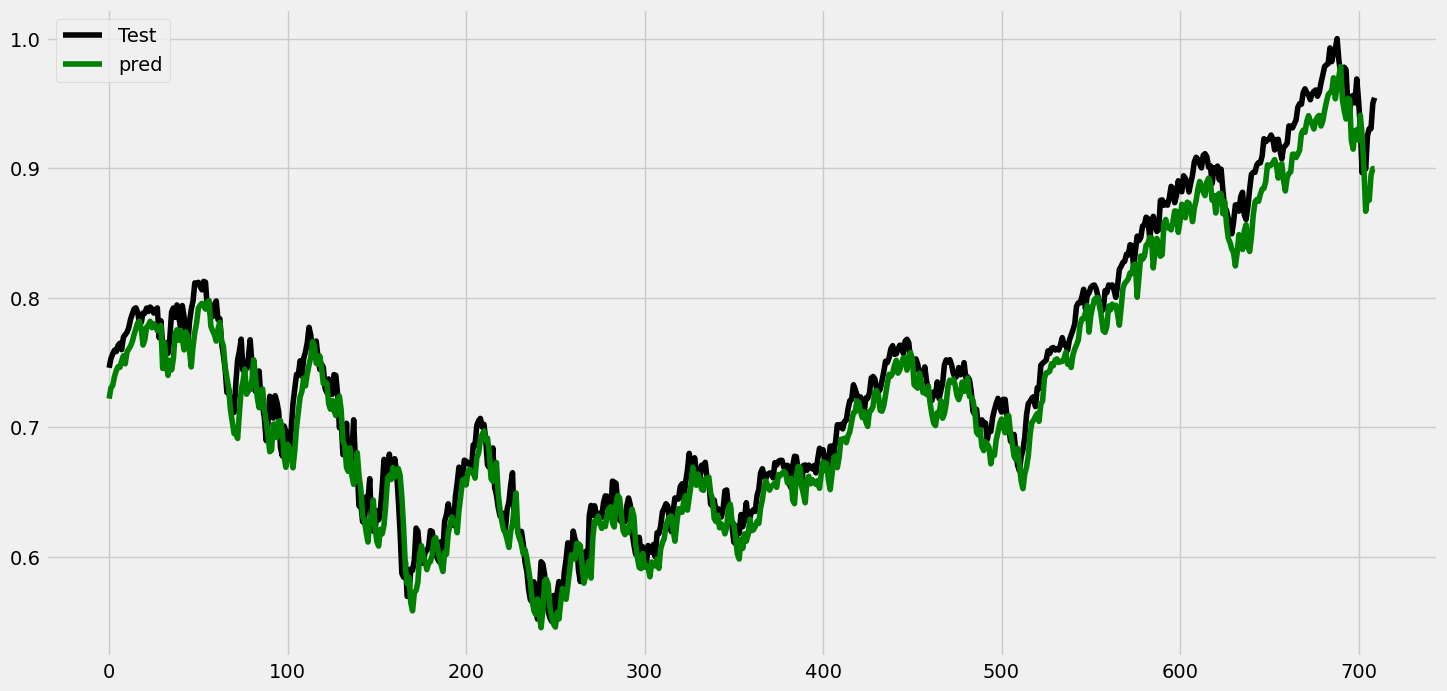

In [49]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()

In [50]:
#calculating mae, mse, rmse

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.01776339587673594
Mean Squared Error: 0.0004520644544933956
Root Mean Squared Error: 0.02126180741360893


All the codes below have the same logic but for different datasets.

### Amazon

In [51]:
amazon.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [52]:
amazon.dropna(inplace=True)
amazon.shape

(3678, 6)

In [53]:
amazon.drop(["Volume"], axis = 1, inplace =True)

In [54]:
amazon['RSI'] = ta.rsi(amazon.Close, length = 14)
amazon['EMAF'] = ta.ema(amazon.Close, length = 20)
amazon['EMAM'] = ta.ema(amazon.Close, length = 50)
amazon['EMAS'] = ta.ema(amazon.Close, length = 100)

amazon['Target'] = amazon['Close']-amazon.Open
amazon['Target'] = amazon['Target'].shift(-1)

amazon['TargetClass'] = [1 if amazon.Target[i]>0 else 0 for i in range(len(amazon))]

amazon['TargetNextClose'] = amazon['Close'].shift(-1)

amazon.dropna(inplace =True)

In [55]:
amazon

,Open,High,Low,Close,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
Date,,,,,,,,,,,,
2010-05-26,6.252500,6.289500,6.115000,6.160500,6.160500,40.137181,6.425078,6.557825,6.468255,0.086000,1,6.335000
2010-05-27,6.249000,6.342500,6.030000,6.335000,6.335000,45.725165,6.416499,6.549087,6.465616,-0.030500,0,6.273000
2010-05-28,6.303500,6.380000,6.200500,6.273000,6.273000,44.148299,6.402832,6.538260,6.461802,-0.086500,0,6.162000
2010-06-01,6.248500,6.328500,6.151000,6.162000,6.162000,41.395912,6.379896,6.523504,6.455865,0.114500,1,6.315500
2010-06-02,6.201000,6.321500,6.082500,6.315500,6.315500,46.374828,6.373763,6.515347,6.453086,0.125500,1,6.438000
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-08-07,166.550003,167.580002,161.429993,162.770004,162.770004,28.918573,178.815805,183.186730,180.539428,0.630005,1,165.800003
2024-08-08,165.169998,166.690002,162.550003,165.800003,165.800003,33.589481,177.576205,182.504897,180.247558,0.540009,1,166.940002
2024-08-09,166.399994,168.550003,165.850006,166.940002,166.940002,35.311813,176.563233,181.894509,179.984042,-1.339996,0,166.800003


In [56]:
sc = MinMaxScaler(feature_range =(0,1))
amazon_scaled = sc.fit_transform(amazon)
print(amazon_scaled)

[[0.00490776 0.00370587 0.00425784 ... 0.41394562 1.         0.00464872]
 [0.00488979 0.00397679 0.00381916 ... 0.40797462 0.         0.00433007]
 [0.00516958 0.00416847 0.00469911 ... 0.40510448 0.         0.00375958]
 ...
 [0.8270476  0.83310803 0.82865402 ... 0.34085884 0.         0.8293669 ]
 [0.83598017 0.83310803 0.82999586 ... 0.53357035 1.         0.84699552]
 [0.83428605 0.84583573 0.8351053  ... 0.30651934 0.         0.84632744]]


In [57]:
X = []

backcandles = 30
print(amazon_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, amazon_scaled.shape[0]):
        X[j].append(amazon_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(amazon_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

3578
[[[4.90776063e-03 3.70587338e-03 4.25784370e-03 ... 2.78066899e-01
   3.00240329e-03 2.81090881e-03]
  [4.88979296e-03 3.97678523e-03 3.81915894e-03 ... 3.59983727e-01
   2.95668437e-03 2.76302708e-03]
  [5.16957696e-03 4.16846774e-03 4.69911248e-03 ... 3.36867719e-01
   2.88385142e-03 2.70370014e-03]
  ...
  [1.21153729e-03 3.16917306e-04 8.25763031e-04 ... 1.90082519e-01
   1.38130527e-04 6.54432150e-04]
  [1.00362641e-03 5.98051503e-04 1.03478534e-03 ... 2.87804429e-01
   2.84404275e-05 5.48541951e-04]
  [2.33323869e-03 1.58202485e-03 2.13408250e-03 ... 3.59631292e-01
   0.00000000e+00 4.76780699e-04]]

 [[4.88979296e-03 3.97678523e-03 3.81915894e-03 ... 3.59983727e-01
   2.95668437e-03 2.76302708e-03]
  [5.16957696e-03 4.16846774e-03 4.69911248e-03 ... 3.36867719e-01
   2.88385142e-03 2.70370014e-03]
  [4.88722510e-03 3.90522145e-03 4.44364186e-03 ... 2.96519217e-01
   2.76161714e-03 2.62284759e-03]
  ...
  [1.00362641e-03 5.98051503e-04 1.03478534e-03 ... 2.87804429e-01
   2.

In [58]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2838
(2838, 30, 8)
(710, 30, 8)
(2838, 1)
(710, 1)
[[0.00280106]
 [0.00386494]
 [0.003775  ]
 ...
 [0.81607603]
 [0.82007969]
 [0.84813141]]


In [59]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3295e-04 - val_loss: 6.0091e-04
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2571e-04 - val_loss: 0.0018
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0544e-04 - val_loss: 0.0011
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 9.5467e-05 - val_loss: 5.9099e-04
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.1664e-04 - val_loss: 6.7706e-04
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.5267e-05 - val_loss: 9.3368e-04
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.0887e-04 - val_loss: 0.0013
Epoch 9/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7.2278e-05 - val_loss: 4.8171e-04
Epoch 10/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.1316e-04 - val_loss: 4.6171e-04
Epoch 11/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6404e-04 - val_l

In [60]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.8349616] [0.85782461]
[0.8657163] [0.85715903]
[0.8763689] [0.84968356]
[0.8762768] [0.85481025]
[0.86688083] [0.82925123]
[0.87162936] [0.82535029]
[0.8420184] [0.83966396]
[0.836153] [0.84388353]
[0.8546859] [0.85778093]
[0.86165565] [0.83872861]


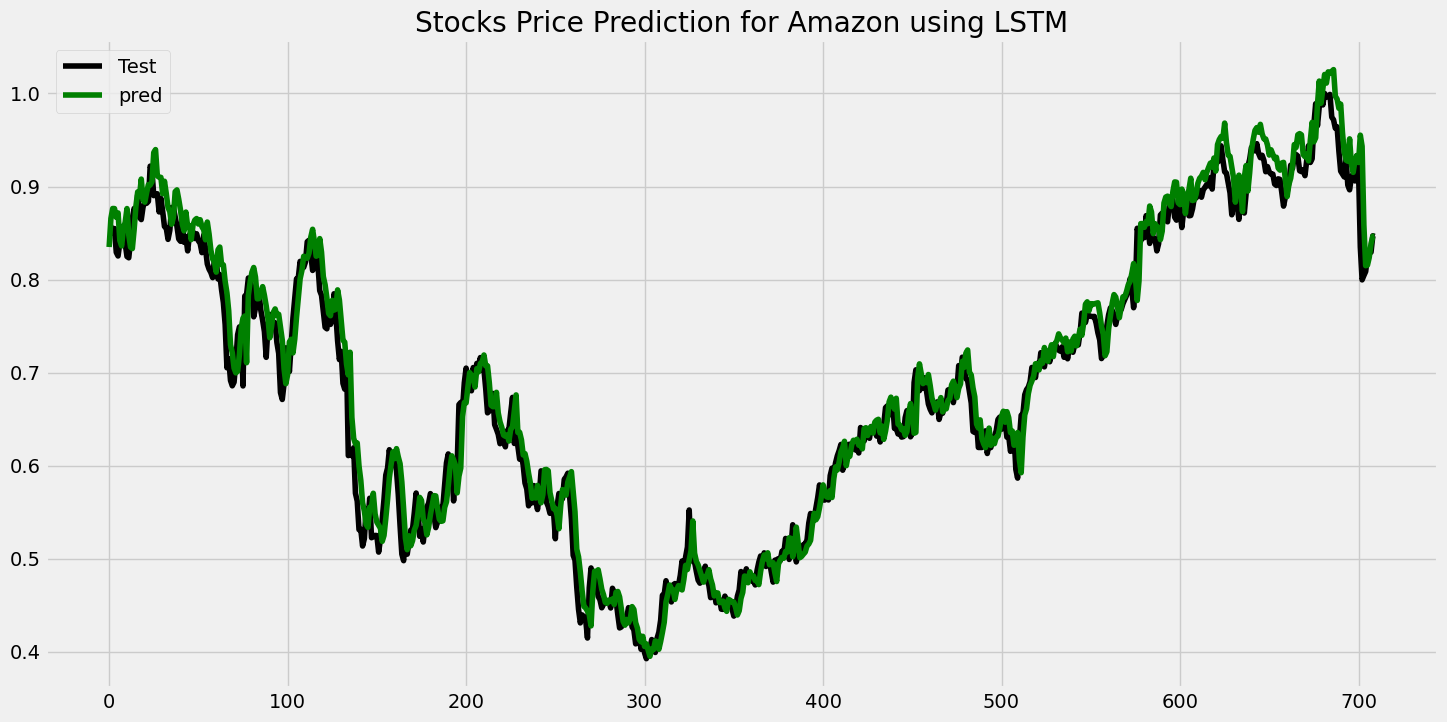

In [61]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.title(f'Stocks Price Prediction for Amazon using LSTM')

plt.legend()
plt.show()

In [62]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.020261335576452728
Mean Squared Error: 0.0007090357724756893
Root Mean Squared Error: 0.026627725634678027


### CAC

In [63]:
cac.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [64]:
cac.dropna(inplace=True)
cac.shape

(3739, 6)

In [65]:
cac.drop(["Volume"], axis = 1, inplace =True)

In [66]:
cac['RSI'] = ta.rsi(cac.Close, length = 14)
cac['EMAF'] = ta.ema(cac.Close, length = 20)
cac['EMAM'] = ta.ema(cac.Close, length = 50)
cac['EMAS'] = ta.ema(cac.Close, length = 100)

cac['Target'] = cac['Close']-cac.Open
cac['Target'] = cac['Target'].shift(-1)

cac['TargetClass'] = [1 if cac.Target[i]>0 else 0 for i in range(len(cac))]

cac['TargetNextClose'] = cac['Close'].shift(-1)

cac.dropna(inplace =True)

In [67]:
sc = MinMaxScaler(feature_range =(0,1))
cac_scaled = sc.fit_transform(cac)
print(cac_scaled)

[[0.10419803 0.09653149 0.10771315 ... 0.54867366 1.         0.11485425]
 [0.11639078 0.11510114 0.12351781 ... 0.67075797 1.         0.13623816]
 [0.12364996 0.12947589 0.13185418 ... 0.46410844 0.         0.13436028]
 ...
 [0.82103069 0.82711269 0.82285031 ... 0.45131083 0.         0.81874971]
 [0.82779952 0.8248939  0.82294278 ... 0.52171279 0.         0.82336656]
 [0.82431125 0.82036785 0.82074631 ... 0.52969898 1.         0.83389908]]


In [68]:
X = []

backcandles = 30
print(cac_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, cac_scaled.shape[0]):
        X[j].append(cac_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(cac_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

3639
[[[0.10419803 0.09653149 0.10771315 ... 0.29428669 0.12240424 0.13352871]
  [0.11639078 0.11510114 0.12351781 ... 0.37525186 0.11880145 0.13089824]
  [0.12364996 0.12947589 0.13185418 ... 0.4817088  0.11769656 0.12928949]
  ...
  [0.11517881 0.10654768 0.11383495 ... 0.34874064 0.11060067 0.10713231]
  [0.11246503 0.10428465 0.1167454  ... 0.35941823 0.1070103  0.10506308]
  [0.11079195 0.09949551 0.1156907  ... 0.34781089 0.10346815 0.10294979]]

 [[0.11639078 0.11510114 0.12351781 ... 0.37525186 0.11880145 0.13089824]
  [0.12364996 0.12947589 0.13185418 ... 0.4817088  0.11769656 0.12928949]
  [0.14550215 0.13416198 0.14642287 ... 0.47471616 0.11650768 0.12766315]
  ...
  [0.11246503 0.10428465 0.1167454  ... 0.35941823 0.1070103  0.10506308]
  [0.11079195 0.09949551 0.1156907  ... 0.34781089 0.10346815 0.10294979]
  [0.10890926 0.11636326 0.11896903 ... 0.46179626 0.10194147 0.10163474]]

 [[0.12364996 0.12947589 0.13185418 ... 0.4817088  0.11769656 0.12928949]
  [0.14550215 0.1

In [69]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2887
(2887, 30, 8)
(722, 30, 8)
(2887, 1)
(722, 1)
[[0.12856726]
 [0.13860884]
 [0.14158229]
 ...
 [0.71233952]
 [0.71889096]
 [0.71532943]]


In [70]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0049 - val_loss: 0.0021
Epoch 2/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 4.4619e-04 - val_loss: 4.8554e-04
Epoch 3/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.2430e-04 - val_loss: 3.3802e-04
Epoch 4/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.8215e-04 - val_loss: 3.3912e-04
Epoch 5/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.7942e-04 - val_loss: 4.0785e-04
Epoch 6/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 2.9755e-04 - val_loss: 4.5023e-04
Epoch 7/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4797e-04 - val_loss: 2.6969e-04
Epoch 8/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3460e-04 - val_loss: 3.9919e-04
Epoch 9/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4988e-04 - val_loss: 3.9573e-04
Epoch 10/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5940e-04 - val_loss: 2.8785e-04
Epoch 11/30
174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4471

In [71]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0.70445853] [0.72403542]
[0.700885] [0.72022109]
[0.7133961] [0.73004824]
[0.707785] [0.72766843]
[0.7170476] [0.73695705]
[0.7137106] [0.74174235]
[0.72331536] [0.75327526]
[0.7257069] [0.75945661]
[0.74053025] [0.76378398]
[0.74397683] [0.77058831]


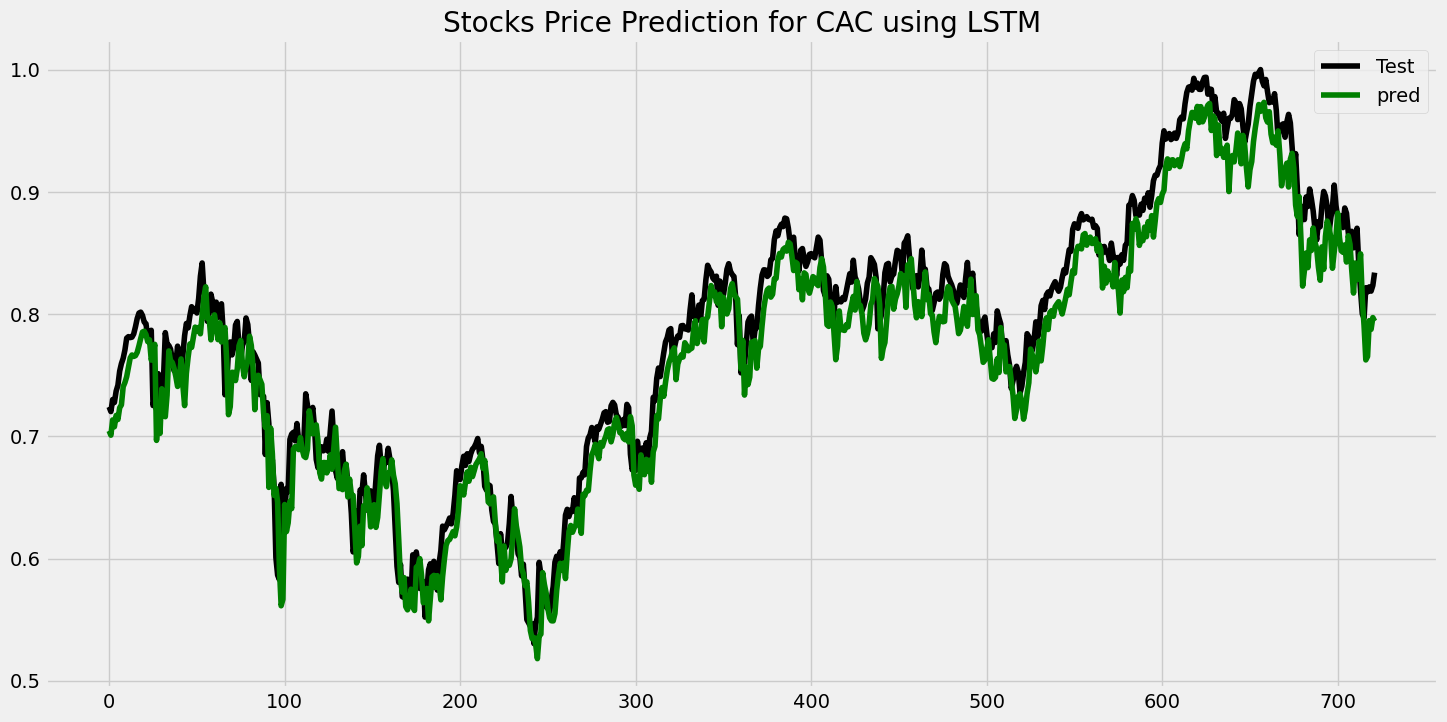

In [72]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.title(f'Stocks Price Prediction for CAC using LSTM')
plt.legend()
plt.show()

In [73]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.022863054139344755
Mean Squared Error: 0.0007385680356387749
Root Mean Squared Error: 0.02717660824383306


### Microsoft

In [74]:
microsoft.dropna(inplace=True)
microsoft.shape

(3678, 6)

In [75]:
microsoft.drop(["Volume"], axis = 1, inplace =True)

In [76]:
microsoft['RSI'] = ta.rsi(microsoft.Close, length = 14)
microsoft['EMAF'] = ta.ema(microsoft.Close, length = 20)
microsoft['EMAM'] = ta.ema(microsoft.Close, length = 50)
microsoft['EMAS'] = ta.ema(microsoft.Close, length = 100)

microsoft['Target'] = microsoft['Close']-microsoft.Open
microsoft['Target'] = microsoft['Target'].shift(-1)

microsoft['TargetClass'] = [1 if microsoft.Target[i]>0 else 0 for i in range(len(microsoft))]

microsoft['TargetNextClose'] = microsoft['Close'].shift(-1)

microsoft.dropna(inplace =True)

In [77]:
sc = MinMaxScaler(feature_range =(0,1))
microsoft_scaled = sc.fit_transform(microsoft)
print(microsoft_scaled)

[[0.0070735  0.00739276 0.0041428  ... 0.42225202 1.         0.0067259 ]
 [0.00594715 0.006831   0.00679148 ... 0.41404007 0.         0.00627601]
 [0.00619495 0.00629171 0.00663301 ... 0.42463608 1.         0.00647846]
 ...
 [0.85814692 0.86450348 0.85919004 ... 0.40847718 0.         0.86334495]
 [0.86497262 0.86609892 0.86367237 ... 0.53218614 1.         0.87954114]
 [0.87067197 0.8800081  0.87573861 ... 0.46966917 1.         0.88595206]]


In [78]:
X = []

backcandles = 30
print(microsoft_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, microsoft_scaled.shape[0]):
        X[j].append(microsoft_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(microsoft_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

3578
[[[0.0070735  0.00739276 0.0041428  ... 0.         0.00923565 0.0104137 ]
  [0.00594715 0.006831   0.00679148 ... 0.17578915 0.0087579  0.01012503]
  [0.00619495 0.00629171 0.00663301 ... 0.16199179 0.00828114 0.00982879]
  ...
  [0.00137415 0.00173022 0.00192425 ... 0.25063536 0.00145087 0.0039201 ]
  [0.00164448 0.00224704 0.00199217 ... 0.32844599 0.0013363  0.00372549]
  [0.00340159 0.00292115 0.00280714 ... 0.34562564 0.00125712 0.00354891]]

 [[0.00594715 0.006831   0.00679148 ... 0.17578915 0.0087579  0.01012503]
  [0.00619495 0.00629171 0.00663301 ... 0.16199179 0.00828114 0.00982879]
  [0.00549661 0.00671865 0.00631608 ... 0.17717144 0.00786982 0.00955266]
  ...
  [0.00164448 0.00224704 0.00199217 ... 0.32844599 0.0013363  0.00372549]
  [0.00340159 0.00292115 0.00280714 ... 0.34562564 0.00125712 0.00354891]
  [0.00279336 0.00244927 0.00321463 ... 0.3289689  0.00115433 0.00336602]]

 [[0.00619495 0.00629171 0.00663301 ... 0.16199179 0.00828114 0.00982879]
  [0.00549661 0.0

In [79]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2838
(2838, 30, 8)
(710, 30, 8)
(2838, 1)
(710, 1)
[[0.00409403]
 [0.00476887]
 [0.0054662 ]
 ...
 [0.61477899]
 [0.62926555]
 [0.63254975]]


In [80]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0019 - val_loss: 2.2163e-04
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 4.2619e-05 - val_loss: 1.6039e-04
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.5432e-05 - val_loss: 1.5821e-04
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.4519e-05 - val_loss: 7.1641e-04
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.0389e-05 - val_loss: 6.2169e-04
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.9507e-05 - val_loss: 2.3797e-04
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.8193e-05 - val_loss: 3.2854e-04
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.7923e-05 - val_loss: 3.1009e-04
Epoch 9/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.1346e-05 - val_loss: 2.1891e-04
Epoch 10/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.4576e-05 - val_loss: 1.3253e-04
Epoch 11/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.

In [81]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0.6397265] [0.63947815]
[0.64465004] [0.64159265]
[0.65045375] [0.63974807]
[0.6548638] [0.6472838]
[0.6541707] [0.64368464]
[0.6584711] [0.64136769]
[0.6570054] [0.64582159]
[0.6546363] [0.67519967]
[0.65930337] [0.67785403]
[0.6816852] [0.69420762]


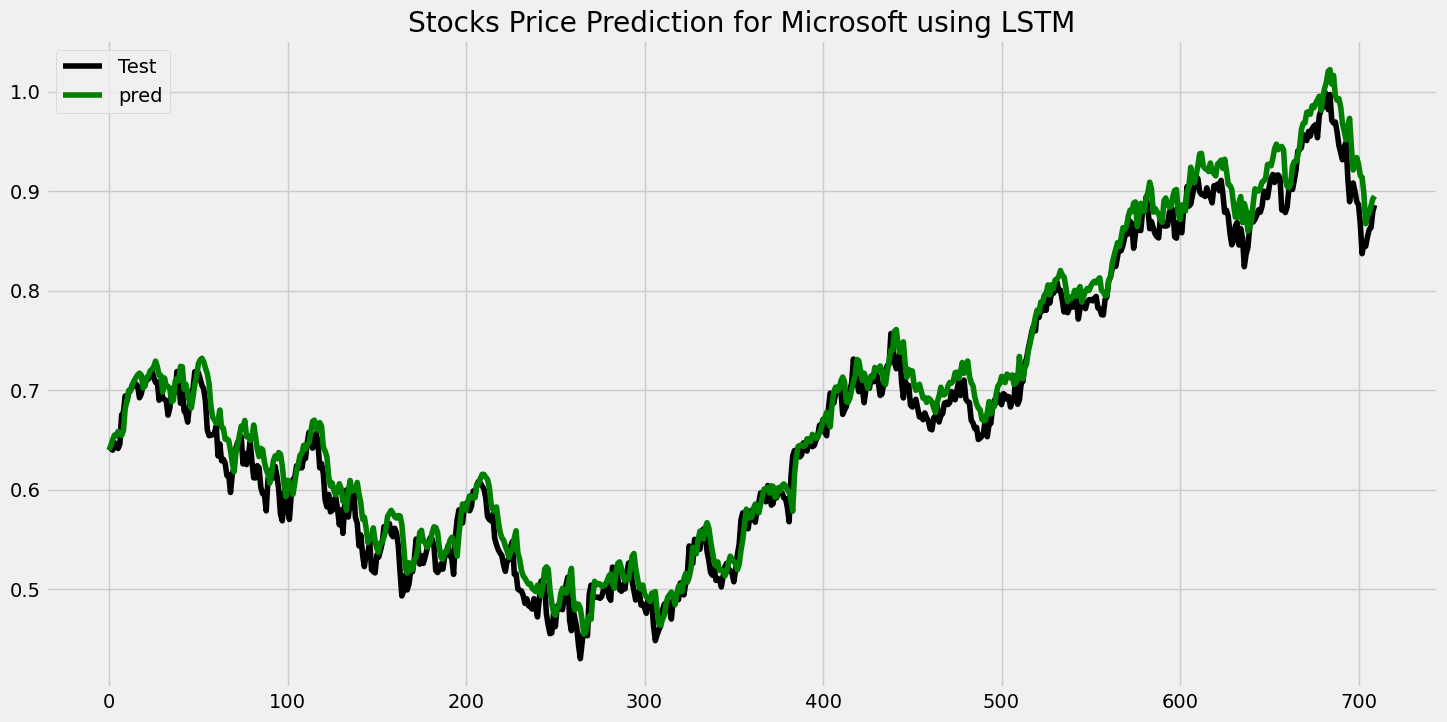

In [82]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.title(f'Stocks Price Prediction for Microsoft using LSTM')
plt.legend()
plt.show()

In [83]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.01807868467163035
Mean Squared Error: 0.0005288166412374323
Root Mean Squared Error: 0.022996013594478334


### IBM

In [84]:
ibm.drop(["Volume"], axis = 1, inplace =True)

In [85]:
ibm['RSI'] = ta.rsi(ibm.Close, length = 14)
ibm['EMAF'] = ta.ema(ibm.Close, length = 20)
ibm['EMAM'] = ta.ema(ibm.Close, length = 50)
ibm['EMAS'] = ta.ema(ibm.Close, length = 100)

ibm['Target'] = ibm['Close']-ibm.Open
ibm['Target'] = ibm['Target'].shift(-1)

ibm['TargetClass'] = [1 if ibm.Target[i]>0 else 0 for i in range(len(ibm))]

ibm['TargetNextClose'] = ibm['Close'].shift(-1)

ibm.dropna(inplace =True)

In [86]:
sc = MinMaxScaler(feature_range =(0,1))
ibm_scaled = sc.fit_transform(ibm)
print(ibm_scaled)

[[0.25078654 0.23865944 0.26216258 ... 0.61175831 1.         0.26125754]
 [0.25211124 0.24246787 0.27646677 ... 0.47842644 0.         0.25192101]
 [0.2596456  0.24153692 0.27258766 ... 0.50130214 0.         0.2443196 ]
 ...
 [0.87244805 0.87805509 0.86613733 ... 0.40317051 0.         0.85454907]
 [0.87305434 0.86876004 0.86579925 ... 0.57203383 1.         0.8675993 ]
 [0.86474032 0.86636985 0.86757449 ... 0.60416559 1.         0.87909383]]


In [87]:
X = []

backcandles = 30
print(ibm_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, ibm_scaled.shape[0]):
        X[j].append(ibm_scaled[i-backcandles:i, j])


X=np.moveaxis(X, [0], [2])


X, yi =np.array(X), np.array(ibm_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

3578
[[[0.25078654 0.23865944 0.26216258 ... 0.34799881 0.15770203 0.10672186]
  [0.25211124 0.24246787 0.27646677 ... 0.46283842 0.15696653 0.10606076]
  [0.2596456  0.24153692 0.27258766 ... 0.43032546 0.1552209  0.10493055]
  ...
  [0.23994039 0.2275728  0.255455   ... 0.3814183  0.1490779  0.09799819]
  [0.23902963 0.24864595 0.26596089 ... 0.50767686 0.14974685 0.09794643]
  [0.27131971 0.25736294 0.29238729 ... 0.5374203  0.15127932 0.09832165]]

 [[0.25211124 0.24246787 0.27646677 ... 0.46283842 0.15696653 0.10606076]
  [0.2596456  0.24153692 0.27258766 ... 0.43032546 0.1552209  0.10493055]
  [0.24913061 0.2466148  0.27186037 ... 0.40447729 0.1527621  0.10344161]
  ...
  [0.23902963 0.24864595 0.26596089 ... 0.50767686 0.14974685 0.09794643]
  [0.27131971 0.25736294 0.29238729 ... 0.5374203  0.15127932 0.09832165]
  [0.27570791 0.25778607 0.29683207 ... 0.53706321 0.15265628 0.09867778]]

 [[0.2596456  0.24153692 0.27258766 ... 0.43032546 0.1552209  0.10493055]
  [0.24913061 0.2

In [88]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2838
(2838, 30, 8)
(710, 30, 8)
(2838, 1)
(710, 1)
[[0.28009586]
 [0.29505081]
 [0.2970338 ]
 ...
 [0.37998846]
 [0.40171863]
 [0.41179868]]


In [89]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0256 - val_loss: 8.1928e-04
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 6.4572e-04
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.7838e-04 - val_loss: 7.7759e-04
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 9.2892e-04 - val_loss: 5.5704e-04
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.8300e-04 - val_loss: 7.7350e-04
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8.8123e-04 - val_loss: 5.2526e-04
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 7.6857e-04 - val_loss: 5.3118e-04
Epoch 9/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 6.5587e-04 - val_loss: 6.0028e-04
Epoch 10/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 7.5106e-04 - val_loss: 6.4947e-04
Epoch 11/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8.0984e-04 - 

In [90]:
y_pred = model.predict(X_test)

for i in range(10):
    print(y_pred[i], y_test[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
[0.3978637] [0.39287781]
[0.4075792] [0.39006863]
[0.38592115] [0.38940755]
[0.37746906] [0.27728661]
[0.37686896] [0.2735685]
[0.2771043] [0.27158557]
[0.26058465] [0.26737174]
[0.2566288] [0.25117737]
[0.2523822] [0.25671317]
[0.23954241] [0.25059904]


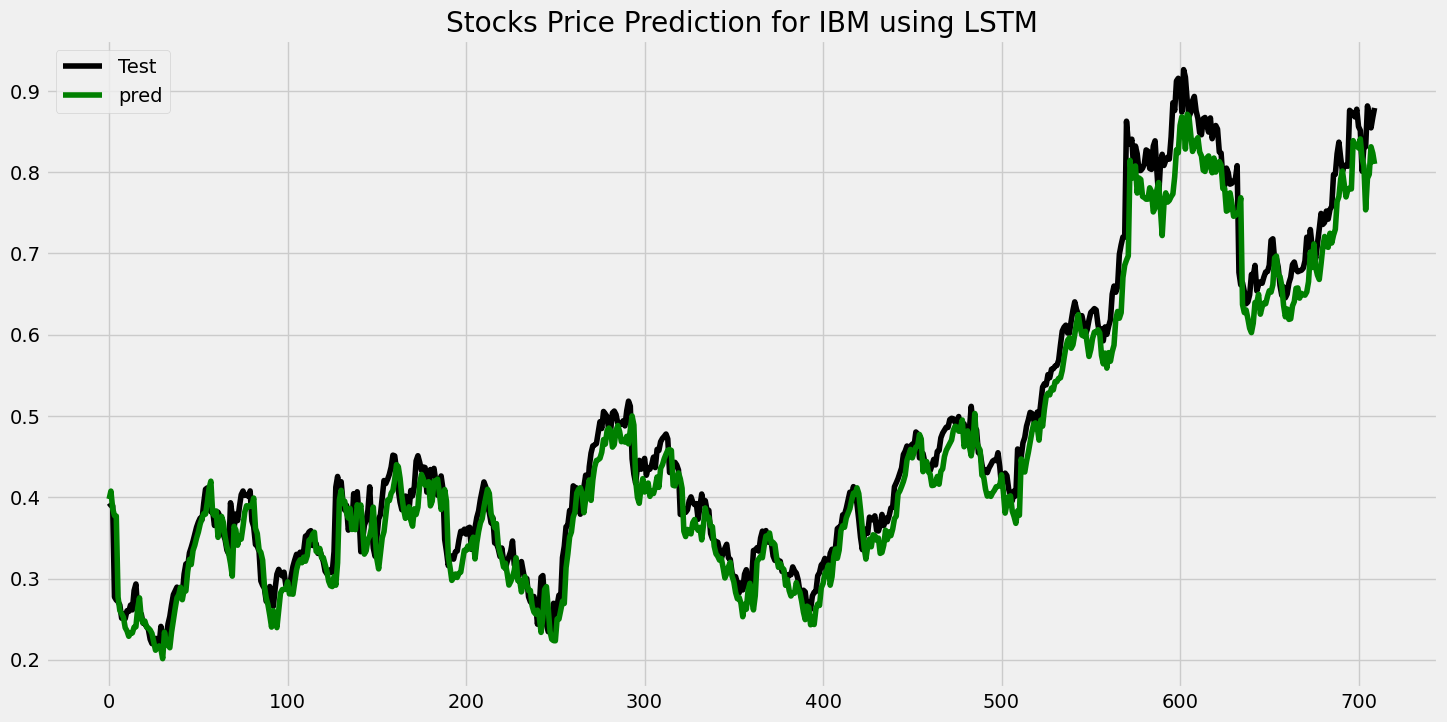

In [91]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.title(f'Stocks Price Prediction for IBM using LSTM')

plt.legend()
plt.show()

In [92]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.027426795729764062
Mean Squared Error: 0.0012188004390961587
Root Mean Squared Error: 0.034911322505688014


### Nasdaq

In [93]:
nasdaq.dropna(inplace=True)
nasdaq.shape

(3678, 6)

In [94]:
nasdaq.drop(["Volume"], axis = 1, inplace =True)

In [95]:
nasdaq['RSI'] = ta.rsi(nasdaq.Close, length = 14)
nasdaq['EMAF'] = ta.ema(nasdaq.Close, length = 20)
nasdaq['EMAM'] = ta.ema(nasdaq.Close, length = 50)
nasdaq['EMAS'] = ta.ema(nasdaq.Close, length = 100)

nasdaq['Target'] = nasdaq['Close']-nasdaq.Open
nasdaq['Target'] = nasdaq['Target'].shift(-1)

nasdaq['TargetClass'] = [1 if nasdaq.Target[i]>0 else 0 for i in range(len(nasdaq))]

nasdaq['TargetNextClose'] = nasdaq['Close'].shift(-1)

nasdaq.dropna(inplace =True)

In [96]:
sc = MinMaxScaler(feature_range =(0,1))
nasdaq_scaled = sc.fit_transform(nasdaq)
print(nasdaq_scaled)

[[0.00764391 0.00885667 0.00788105 ... 0.38374752 1.         0.01122818]
 [0.00876593 0.01012718 0.01088475 ... 0.34688888 0.         0.00998148]
 [0.0105999  0.01005049 0.01099447 ... 0.34377452 0.         0.00788492]
 ...
 [0.87785142 0.88636455 0.88461789 ... 0.35058752 0.         0.88723857]
 [0.88733964 0.89279968 0.89222589 ... 0.53549604 1.         0.91182231]
 [0.89646424 0.91073402 0.90713215 ... 0.3346837  0.         0.91212373]]


In [97]:
X = []

backcandles = 30
print(nasdaq_scaled.shape[0])
for j in range(8):
    X.append([])
    for i in range(backcandles, nasdaq_scaled.shape[0]):
        X[j].append(nasdaq_scaled[i-backcandles:i, j])

X=np.moveaxis(X, [0], [2])

X, yi =np.array(X), np.array(nasdaq_scaled[backcandles:,-1])
y=np.reshape(yi,(len(yi),1))

print(X)
print(X.shape)
print(y)
print(y.shape)

3578
[[[7.64391374e-03 8.85667459e-03 7.88105447e-03 ... 2.08520778e-01
   8.88427281e-03 9.43566972e-03]
  [8.76592690e-03 1.01271769e-02 1.08847548e-02 ... 3.86539069e-01
   8.64002322e-03 9.23426032e-03]
  [1.05999018e-02 1.00504868e-02 1.09944708e-02 ... 3.56803966e-01
   8.29538348e-03 8.98795717e-03]
  ...
  [1.36598292e-03 1.54827906e-03 1.01363408e-03 ... 1.76391538e-01
   1.25041791e-03 3.12124707e-03]
  [0.00000000e+00 2.96672158e-03 2.25339650e-03 ... 3.66236818e-01
   1.02501533e-03 2.86510784e-03]
  [4.54721696e-03 4.26560303e-03 5.42774958e-03 ... 4.05397695e-01
   9.16514655e-04 2.65975844e-03]]

 [[8.76592690e-03 1.01271769e-02 1.08847548e-02 ... 3.86539069e-01
   8.64002322e-03 9.23426032e-03]
  [1.05999018e-02 1.00504868e-02 1.09944708e-02 ... 3.56803966e-01
   8.29538348e-03 8.98795717e-03]
  [8.76411349e-03 1.00679860e-02 9.73702998e-03 ... 3.09118792e-01
   7.77562187e-03 8.66253276e-03]
  ...
  [0.00000000e+00 2.96672158e-03 2.25339650e-03 ... 3.66236818e-01
   1.

In [98]:
# split data into train test sets
splitlimit = int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train)

2838
(2838, 30, 8)
(710, 30, 8)
(2838, 1)
(710, 1)
[[0.00643708]
 [0.00907484]
 [0.00954659]
 ...
 [0.7538117 ]
 [0.7690204 ]
 [0.77348474]]


In [99]:
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0072 - val_loss: 6.5393e-04
Epoch 2/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 6.6512e-05 - val_loss: 2.5924e-04
Epoch 3/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 5.7874e-05 - val_loss: 3.9716e-04
Epoch 4/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.7311e-05 - val_loss: 2.6367e-04
Epoch 5/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.5686e-05 - val_loss: 2.9074e-04
Epoch 6/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.6298e-05 - val_loss: 2.2977e-04
Epoch 7/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2134e-05 - val_loss: 4.0423e-04
Epoch 8/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.2934e-05 - val_loss: 4.6752e-04
Epoch 9/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 5.4924e-05 - val_loss: 2.6590e-04
Epoch 10/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.9096e-05 - val_loss: 3.3588e-04
Epoch 11/30
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 3.

In [100]:
y_pred = model.predict(X_test)
for i in range(10):
    print(y_pred[i], y_test[i])

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
[0.7769811] [0.781003]
[0.7851351] [0.78748298]
[0.7916942] [0.78703539]
[0.7997516] [0.79271444]
[0.8011747] [0.78513395]
[0.8066903] [0.79337946]
[0.79890007] [0.79392308]
[0.80792874] [0.79393092]
[0.8138643] [0.80675314]
[0.8163638] [0.80978954]


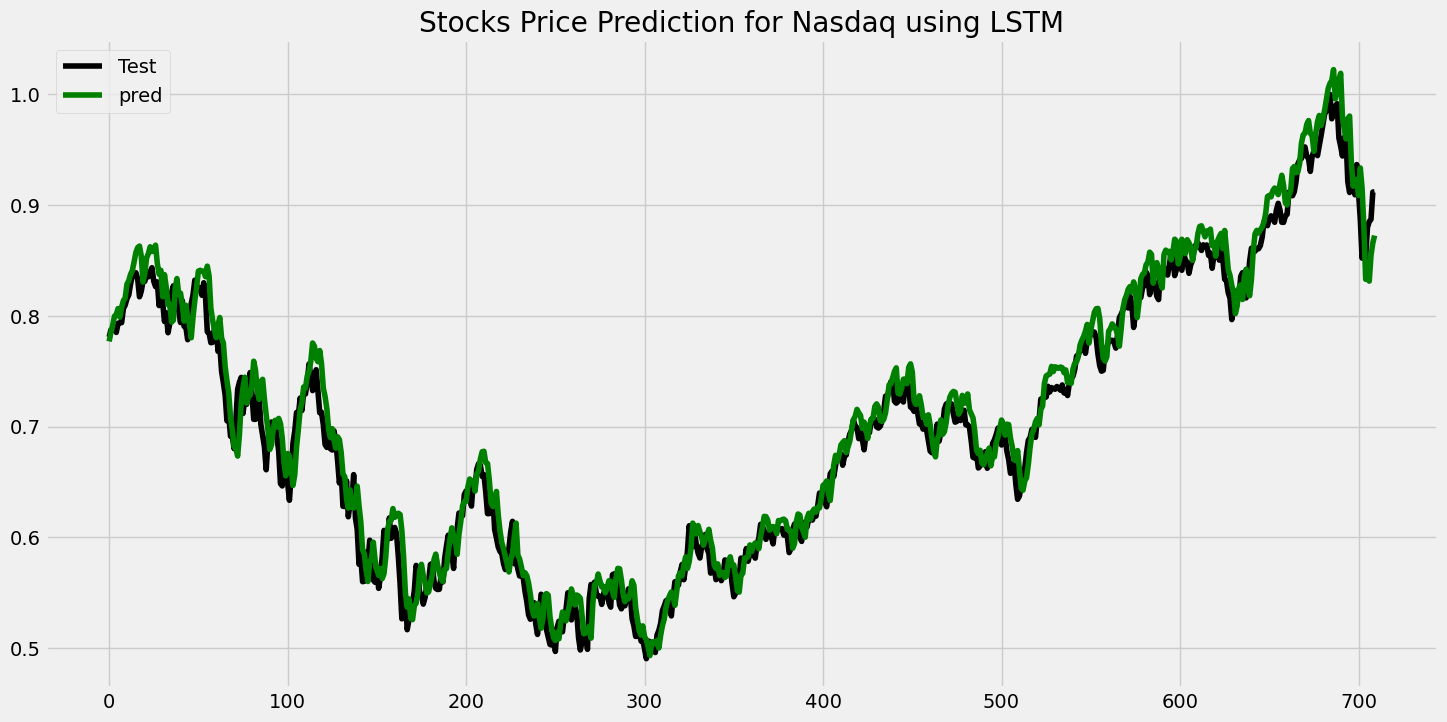

In [101]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.title(f'Stocks Price Prediction for Nasdaq using LSTM')

plt.legend()
plt.show()

In [102]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error: 0.016351693482316822
Mean Squared Error: 0.00042953315858795094
Root Mean Squared Error: 0.02072518175042021


## Conclusion on LSTM
+ The best RMSE on 6 datasets with LSTM is 0.034 on SP500.
+ The worst RMSE is 0.108 on AMAZON.

# Conclusion of overall project

+ We can remark that both models had highest RMSE in Amazon data frame due to *steppe fall* of Amazon stock prices in 2022, while they did better in more stable data - Models perform better in stable environment
+ If I had more time, future research would be devoted to the development of other models and algorithms to compare the results between them and also applying sentiment analysis would also be added to make performance more efficient.
